# Clustering of time series gas prices in Europe

# Data loading
Main source: [eurostat](https://ec.europa.eu/eurostat/web/main/home)

*   [Bi-annual gas prices for houssehold consumers from 2007](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nrg_pc_202&lang=en)
*   [Bi-annual gas prices for non-household consumers from 2007](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nrg_pc_203&lang=en)
*   [Bi-annual data for domestic consumers until 2007](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nrg_pc_202_h&lang=en)
*   [Bi-annual data for industrial consumers until 2007](https://appsso.eurostat.ec.europa.eu/nui/show.do?dataset=nrg_pc_203_h&lang=en)



In [2]:
# import libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
# from google.colab import files
import seaborn as sns
sns.set()
%matplotlib inline
!pwd

/Users/xena/Documents/University/6_mr/sem+lec_2023/14_cluster/time-series-clustering-main/clustering


In [47]:
# Dataset names in https://ec.europa.eu/eurostat/web/main/data/database

DOMESTIC_UNTIL_2007 = 'nrg_pc_202_h'
DOMESTIC_FROM_2007 = 'nrg_pc_202'

INDUSTRIAL_UNTIL_2007 = 'nrg_pc_203_h'
INDUSTRIAL_FROM_2007 = 'nrg_pc_203'

datasets_names = [
    DOMESTIC_UNTIL_2007, 
    DOMESTIC_FROM_2007,
    INDUSTRIAL_UNTIL_2007,
    INDUSTRIAL_FROM_2007
    ]

In [48]:
# Remove data from previous session
!rm -r eurostat_data

# Create a directory to store data from eurostat
!mkdir eurostat_data

In [49]:
# Download data from eurostat
for dataset in datasets_names:
  output_gz_file = f'eurostat_data/{dataset}.tsv.gz'
  !wget -O {output_gz_file} https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/{dataset}.tsv.gz

  output_tsv_file = f'eurostat_data/{dataset}.tsv'
  !gunzip -c {output_gz_file} > {output_tsv_file}
  !rm {output_gz_file}

%ls eurostat_data

--2023-01-06 08:50:52--  https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_pc_202_h.tsv.gz
Resolving ec.europa.eu (ec.europa.eu)... 147.67.210.30, 147.67.34.30, 2a01:7080:24:100::666:30, ...
Connecting to ec.europa.eu (ec.europa.eu)|147.67.210.30|:443... connected.
HTTP request sent, awaiting response... 200 
Cookie coming from ec.europa.eu attempted to set domain to europa.eu/eurostat
Length: 56029 (55K) [application/octet-stream]
Saving to: ‘eurostat_data/nrg_pc_202_h.tsv.gz’

eurostat_data/nrg_p 100%[===================>]  54.72K  --.-KB/s    in 0.1s    

2023-01-06 08:50:53 (503 KB/s) - ‘eurostat_data/nrg_pc_202_h.tsv.gz’ saved [56029/56029]

--2023-01-06 08:50:53--  https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_pc_202.tsv.gz
Resolving ec.europa.eu (ec.europa.eu)... 147.67.210.30, 147.67.34.30, 2a01:7080:24:100::666:30, ...
Connecting to ec.europa.eu (ec.europa.eu)|147.67.210.30|:443... connected.

# Data preprocessing
## Convert eurostat data to data frames

In [50]:
# Working with domestic sector

df_u2007 = pd.read_csv(f'eurostat_data/{DOMESTIC_UNTIL_2007}.tsv', sep='\t')
df_f2007 = pd.read_csv(f'eurostat_data/{DOMESTIC_FROM_2007}.tsv', sep='\t')


df_u2007

product,consom,unit,tax,currency,geo\time   2007S2     2007S1    2006S2   \
0             4100,4141050,GJ_GCV,I_TAX,EUR,AT  24.1000    24.1000   23.4900    
1             4100,4141050,GJ_GCV,I_TAX,EUR,BE  20.4500    21.5600   22.6400    
2             4100,4141050,GJ_GCV,I_TAX,EUR,BG   7.2922     7.7099    8.2314    
3             4100,4141050,GJ_GCV,I_TAX,EUR,CZ  12.8696    12.7604   13.3461    
4             4100,4141050,GJ_GCV,I_TAX,EUR,DE  27.7400    28.5200   27.1700    
...                                        ...       ...        ...       ...   
1687          4100,4141300,GJ_GCV,X_TAX,PPS,UK  9.2962 p  10.4414 p   8.8757    
1688          4100,4141300,GJ_GCV,X_VAT,EUR,UK  10.2313    11.6821    9.8136    
1689          4100,4141300,GJ_GCV,X_VAT,NAC,UK   6.9000     7.7500    6.7500    
1690          4100,4141300,GJ_GCV,X_VAT,NAT,UK   6.9000     7.7500    6.7500    
1691          4100,4141300,GJ_GCV,X_VAT,PPS,UK  9.2962 p  10.4414 p   8.8757    

       2006S1    2005S2    2005S1    2004S2    2004S1    2003S2   ...  \
0     23.4900   21.6200   21.1700   21.1700   21.5600         :   ...   
1     21.8600   20.1900   19.1000         :         :         :   ...   
2      7.8755    6.9404    6.6711    6.8156    6.7572         :   ...   
3     13.0757   11.3237   11.1134    9.8783    9.9886    9.6137   ...   
4     26.0900   23.9000   24.2500   22.1100   22.1380   22.1400   ...   
...        ...       ...       ...       ...       ...       ...  ...   
1687   7.3636    6.9136    6.8322    6.1329    7.2504    6.8486   ...   
1688   8.1635    7.4175    7.2137    6.7592    7.6862    7.2097   ...   
1689   5.6000    5.1000    5.0400    4.5000    5.3200    5.0500   ...   
1690   5.6000    5.1000    5.0400    4.5000    5.3200    5.0500   ...   
1691   7.3636    6.9136    6.8322    6.1329    7.2504    6.8486   ...   

       1992S1    1991S2    1991S1  1990S2    1990S1    1989S1    1988S1   \
0           :         :         :       :         :         :         :    
1           :         :         :       :         :         :         :    
2           :         :         :       :         :         :         :    
3           :         :         :       :         :         :         :    
4     15.3309   15.2847   14.8965       :   15.9197   14.6343   14.7910    
...        ...       ...       ...     ...       ...       ...       ...   
1687   8.0369    8.1069    7.8706       :         :         :         :    
1688   7.6870    7.8751    7.5941       :         :         :         :    
1689   5.4900    5.4900    5.3300       :         :         :         :    
1690   5.4900    5.4900    5.3300       :         :         :         :    
1691   8.0369    8.1069    7.8706       :         :         :         :    

       1987S1    1986S1    1985S1   
0           :         :         :   
1           :         :         :   
2           :         :         :   
3           :         :         :   
4     15.8779   18.6482   18.1230   
...        ...       ...       ...  
1687        :         :         :   
1688        :         :         :   
1689        :         :         :   
1690        :         :         :   
1691        :         :         :   

[1692 rows x 42 columns]

In [51]:
# original data, do not change
original_data = np.array([df_u2007, df_f2007], dtype=object)

# mutating data
data = original_data.copy()

## Splitting first column


In [52]:
def split_column(df, column_to_split):
  new_columns_names = column_to_split.split(',')

  first_cols = df.iloc[:, 0].str.split(',', expand = True)

  old_new_names_map = dict(zip(first_cols.columns, new_columns_names))
  first_cols.rename(columns=old_new_names_map, inplace=True)

  df = pd.concat([df, first_cols], axis=1)
  df.drop(columns = df.columns[0], axis = 1, inplace= True)
  return df


In [53]:
for index, df in enumerate(data):
  new_df = split_column(df, df.iloc[:, 0].name)
  data[index] = new_df

## Identifying NA

In [54]:
def identify_na(df, replacements):
  for key, value in replacements.items():
    for column in df.columns:
      df[column] = df[column].replace(key, value)
  return df

In [55]:
for index, df in enumerate(data):
  new_df = identify_na(df, {': ': np.nan})
  new_df = identify_na(df, {': c': np.nan})
  data[index] = new_df

## Filtering data from redundant values and columns

In [56]:
# We need to choose only one value for product, consom, unit, tax, and currency 
countries_map = {
                    "EU27_2020": "European Union - 27 countries (from 2020)",
                    "EU27_2007": "European Union - 27 countries (2007-2013)",
                    "EA": "Euro area",
                    "EU15": "European Union - 15 countries (1995-2004)",
                    "EU25": "European Union - 25 countries (2004-2006)",
                    "BE": "Belgium",
                    "BG": "Bulgaria",
                    "CZ": "Czechia",
                    "DK": "Denmark",
                    "DE": "Germany",
                    "EE": "Estonia",
                    "IE": "Ireland",
                    "EL": "Greece",
                    "ES": "Spain",
                    "FR": "France",
                    "HR": "Croatia",
                    "IT": "Italy",
                    "LV": "Latvia",
                    "LT": "Lithuania",
                    "LU": "Luxembourg",
                    "HU": "Hungary",
                    "NL": "Netherlands",
                    "AT": "Austria",
                    "PL": "Poland",
                    "PT": "Portugal",
                    "FI": "Finland",
                    "RO": "Romania",
                    "SI": "Slovenia",
                    "SK": "Slovakia",
                    "SE": "Sweden",
                    "LI": "Liechtenstein",
                    "UK": "United Kingdom",
                    "MK": "North Macedonia",
                    "RS": "Serbia",
                    "TR": "Türkiye",
                    "BA": "Bosnia and Herzegovina",
                    "MD": "Moldova",
                    "UA": "Ukraine",
                    "GE": "Georgia",
                    "AL": "Albania",
                }
product_labels = {
                    "4100": "Natural gas"
                }

consom_domestic_f2007_labels = {
                    "4141902": "Band D2 : 20 GJ < Consumption < 200 GJ",
                }

consom_domestic_u2007_labels = {
                    "4141150": "Households - D3 (Annual consumption: 83.70 GJ)",
                }

consom_industrial_f2007_labels = {
                    "4142903": "Band I3 : 10 000 GJ < Consumption < 100 000 GJ",
                }

consom_industrial_u2007_labels = {
                    "4142150": "Industry - I3-1 (Annual consumption: 41 860 GJ; load factor: 200 days, 1 600 hours) (for Belgium: fixed supply (non-erasable) for non-specific applications that can easily be substituted by residual fuel oils (CNE 1 P 1))",
                }

# Imporant columns names
GEO = 'geo\\time'
TAX = 'tax'
CURRENCY = 'currency'
UNIT = 'unit'
CONSOM = 'consom'
PRODUCT = 'product'

non_values_columns = [
    GEO,
    TAX,
    CURRENCY,
    UNIT,
    CONSOM,
    PRODUCT,
]

columns_to_filter = [
    TAX,
    CURRENCY,
    UNIT,
    CONSOM,
    PRODUCT
]

filtering_values = {TAX: 'I_TAX', CURRENCY: 'EUR', UNIT: 'GJ_GCV', CONSOM: ['4141150', '4141902'], PRODUCT: '4100'}

In [57]:
# Find columns with more that 50% of nan values
def define_columns_with_nan_values(df):
  columns_with_nan_values = []
  all_columns = df.columns
  for column in all_columns:
    na_count = df[column].isna().sum()
    length = df.shape[0]
    if (na_count/length) >= 0.5:
      columns_with_nan_values.append(column)
  return columns_with_nan_values

columns_with_nan_values = []

for df in data:
  df_nan_columns =define_columns_with_nan_values(df)
  columns_with_nan_values.extend(df_nan_columns)

columns_with_nan_values = list(set(columns_with_nan_values))

In [58]:
# Filter values (choosing one tax category, one consumption category etc)
def filter_columns(df, columns, filtering_values):
  for column in columns:
    value = filtering_values[column]
    if type(value) == np.ndarray or type(value) == list:
      df = df[df[column].isin(value)]
    else:
      df = df[df[column] == value]
  return df

for index, df in enumerate(data):
  new_df = filter_columns(df, columns_to_filter, filtering_values)
  data[index] = new_df

In [59]:
# Add column "country", which contains full country name
COUNTRY = 'country'
non_values_columns.append(COUNTRY)

for index, df in enumerate(data):
  df[COUNTRY] = df[GEO].apply(lambda x: countries_map[x])
  df = df[df[COUNTRY] != "Euro area"]
  data[index] = df

## Transposing and concatting


### Transpose prices columns

In [60]:
# create df with only prices columns
transposed_data = []

for df in data:
  # choosing only prices columns
  transposed_df = df.drop(non_values_columns, axis=1).transpose()
  # adding countries as column names
  transposed_df.set_axis(df[COUNTRY].values, axis=1, inplace=True)
  transposed_data.append(transposed_df)

print(transposed_data[0].shape)
print(transposed_data[1].shape)

(41, 29)
(31, 35)


### Concat dataframes

In [61]:
df = pd.concat([transposed_data[1], transposed_data[0]], join="inner")
df

Austria   Belgium  Bulgaria   Czechia   Germany   Denmark   Estonia  \
2022S1   21.2942   26.0893   21.2110   28.0601   22.3901   44.4309   30.7210    
2021S2        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2021S1   17.6667   13.0023   10.2154   15.6045   17.9618   24.8473   12.0958    
2020S2   18.2267   13.8374    9.6658   15.5124   17.2123   20.7421   11.4294    
2020S1   17.9895   13.7697   11.0110   15.9069   16.5765   20.8287   12.2553    
...           ...       ...       ...       ...       ...       ...       ...   
1989S1        NaN       NaN       NaN       NaN   6.4055        NaN       NaN   
1988S1        NaN       NaN       NaN       NaN   6.4344        NaN       NaN   
1987S1        NaN       NaN       NaN       NaN   7.0913        NaN       NaN   
1986S1        NaN       NaN       NaN       NaN   9.5973        NaN       NaN   
1985S1        NaN       NaN       NaN       NaN   9.3290        NaN       NaN   

            Spain    France   Croatia  ...    Latvia Netherlands    Poland  \
2022S1   24.9262   23.6140   11.4568   ...  12.8343     34.5436   15.2502    
2021S2        NaN       NaN       NaN  ...       NaN         NaN       NaN   
2021S1   19.2038   19.1936   10.4009   ...   8.2612     26.6970   10.4510    
2020S2   24.7144   20.8706   10.4856   ...   7.7734     28.0512   11.6451    
2020S1   19.9309   19.9882   10.7964   ...   8.7451     27.6403   11.8064    
...           ...       ...       ...  ...       ...         ...       ...   
1989S1        NaN       NaN       NaN  ...       NaN         NaN       NaN   
1988S1        NaN       NaN       NaN  ...       NaN         NaN       NaN   
1987S1        NaN       NaN       NaN  ...       NaN         NaN       NaN   
1986S1        NaN       NaN       NaN  ...       NaN         NaN       NaN   
1985S1        NaN       NaN       NaN  ...       NaN         NaN       NaN   

         Portugal    Romania     Sweden  Slovenia  Slovakia  Türkiye  \
2022S1   23.2423   16.9686 e  61.5534 e  19.1926   13.5520   4.7256    
2021S2        NaN        NaN        NaN       NaN       NaN      NaN   
2021S1   21.1719    8.7997 e  34.2754 e  15.1826   11.4100   5.2567    
2020S2   21.7370     8.8977   29.8037 e  15.2638   13.3260   5.4015    
2020S1   21.8115    8.9980 e  27.2216 e  16.2754   12.7040   6.6503    
...           ...        ...        ...       ...       ...      ...   
1989S1        NaN        NaN        NaN       NaN       NaN      NaN   
1988S1        NaN        NaN        NaN       NaN       NaN      NaN   
1987S1        NaN        NaN        NaN       NaN       NaN      NaN   
1986S1        NaN        NaN        NaN       NaN       NaN      NaN   
1985S1        NaN        NaN        NaN       NaN       NaN      NaN   

        United Kingdom  
2022S1             NaN  
2021S2             NaN  
2021S1             NaN  
2020S2             NaN  
2020S1        13.2185   
...                ...  
1989S1             NaN  
1988S1             NaN  
1987S1             NaN  
1986S1             NaN  
1985S1             NaN  

[72 rows x 25 columns]

## Remove NA


In [62]:
# fill na, if row has neighbour with values
df.fillna(method ='bfill', inplace=True)

# drop row if it has 70% of na
threshhold = len(df.columns) * 0.7
df.dropna(axis=0, thresh=threshhold, inplace=True)

# fill the rest
df.fillna(method ='ffill', inplace=True)

## Convert types

In [63]:
# convert pricces to floats
df = df.apply(lambda x: x.apply(lambda x: x.split(' ')[0] if not isinstance(x, float) else x).astype(float))

In [64]:
# convert indices to datetime
def to_date_converter_helper(string):
  splitted_s = string.split('S')
  year = int(splitted_s[0])
  year_half = splitted_s[1]
  if year_half == '1 ':
    return datetime.datetime(year, 1, 1)
  else:
    return datetime.datetime(year, 7, 1)  

df.index = df.index.map(to_date_converter_helper)

## Scaling

In [317]:
import sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

s_scaler = StandardScaler()
m_scaler = MinMaxScaler()
r_scaler = RobustScaler()

final_df = df.sort_index(ascending=True)
scaled_df = pd.DataFrame(s_scaler.fit_transform(df), columns=df.columns, index=df.index).sort_index(ascending=True)
# final_min_max_scaled_df = pd.DataFrame(m_scaler.fit_transform(final_df), columns=final_df.columns, index=final_df.index).sort_index(ascending=True)

## Plot time series

In [310]:
import math

def optimal_subplot_dimensions(n: int) -> tuple:
    rows = math.ceil(math.sqrt(n))
    cols = math.ceil(n / rows)
    while n % cols != 0:
        rows += 1
        cols = math.ceil(n / rows)
    return rows, cols

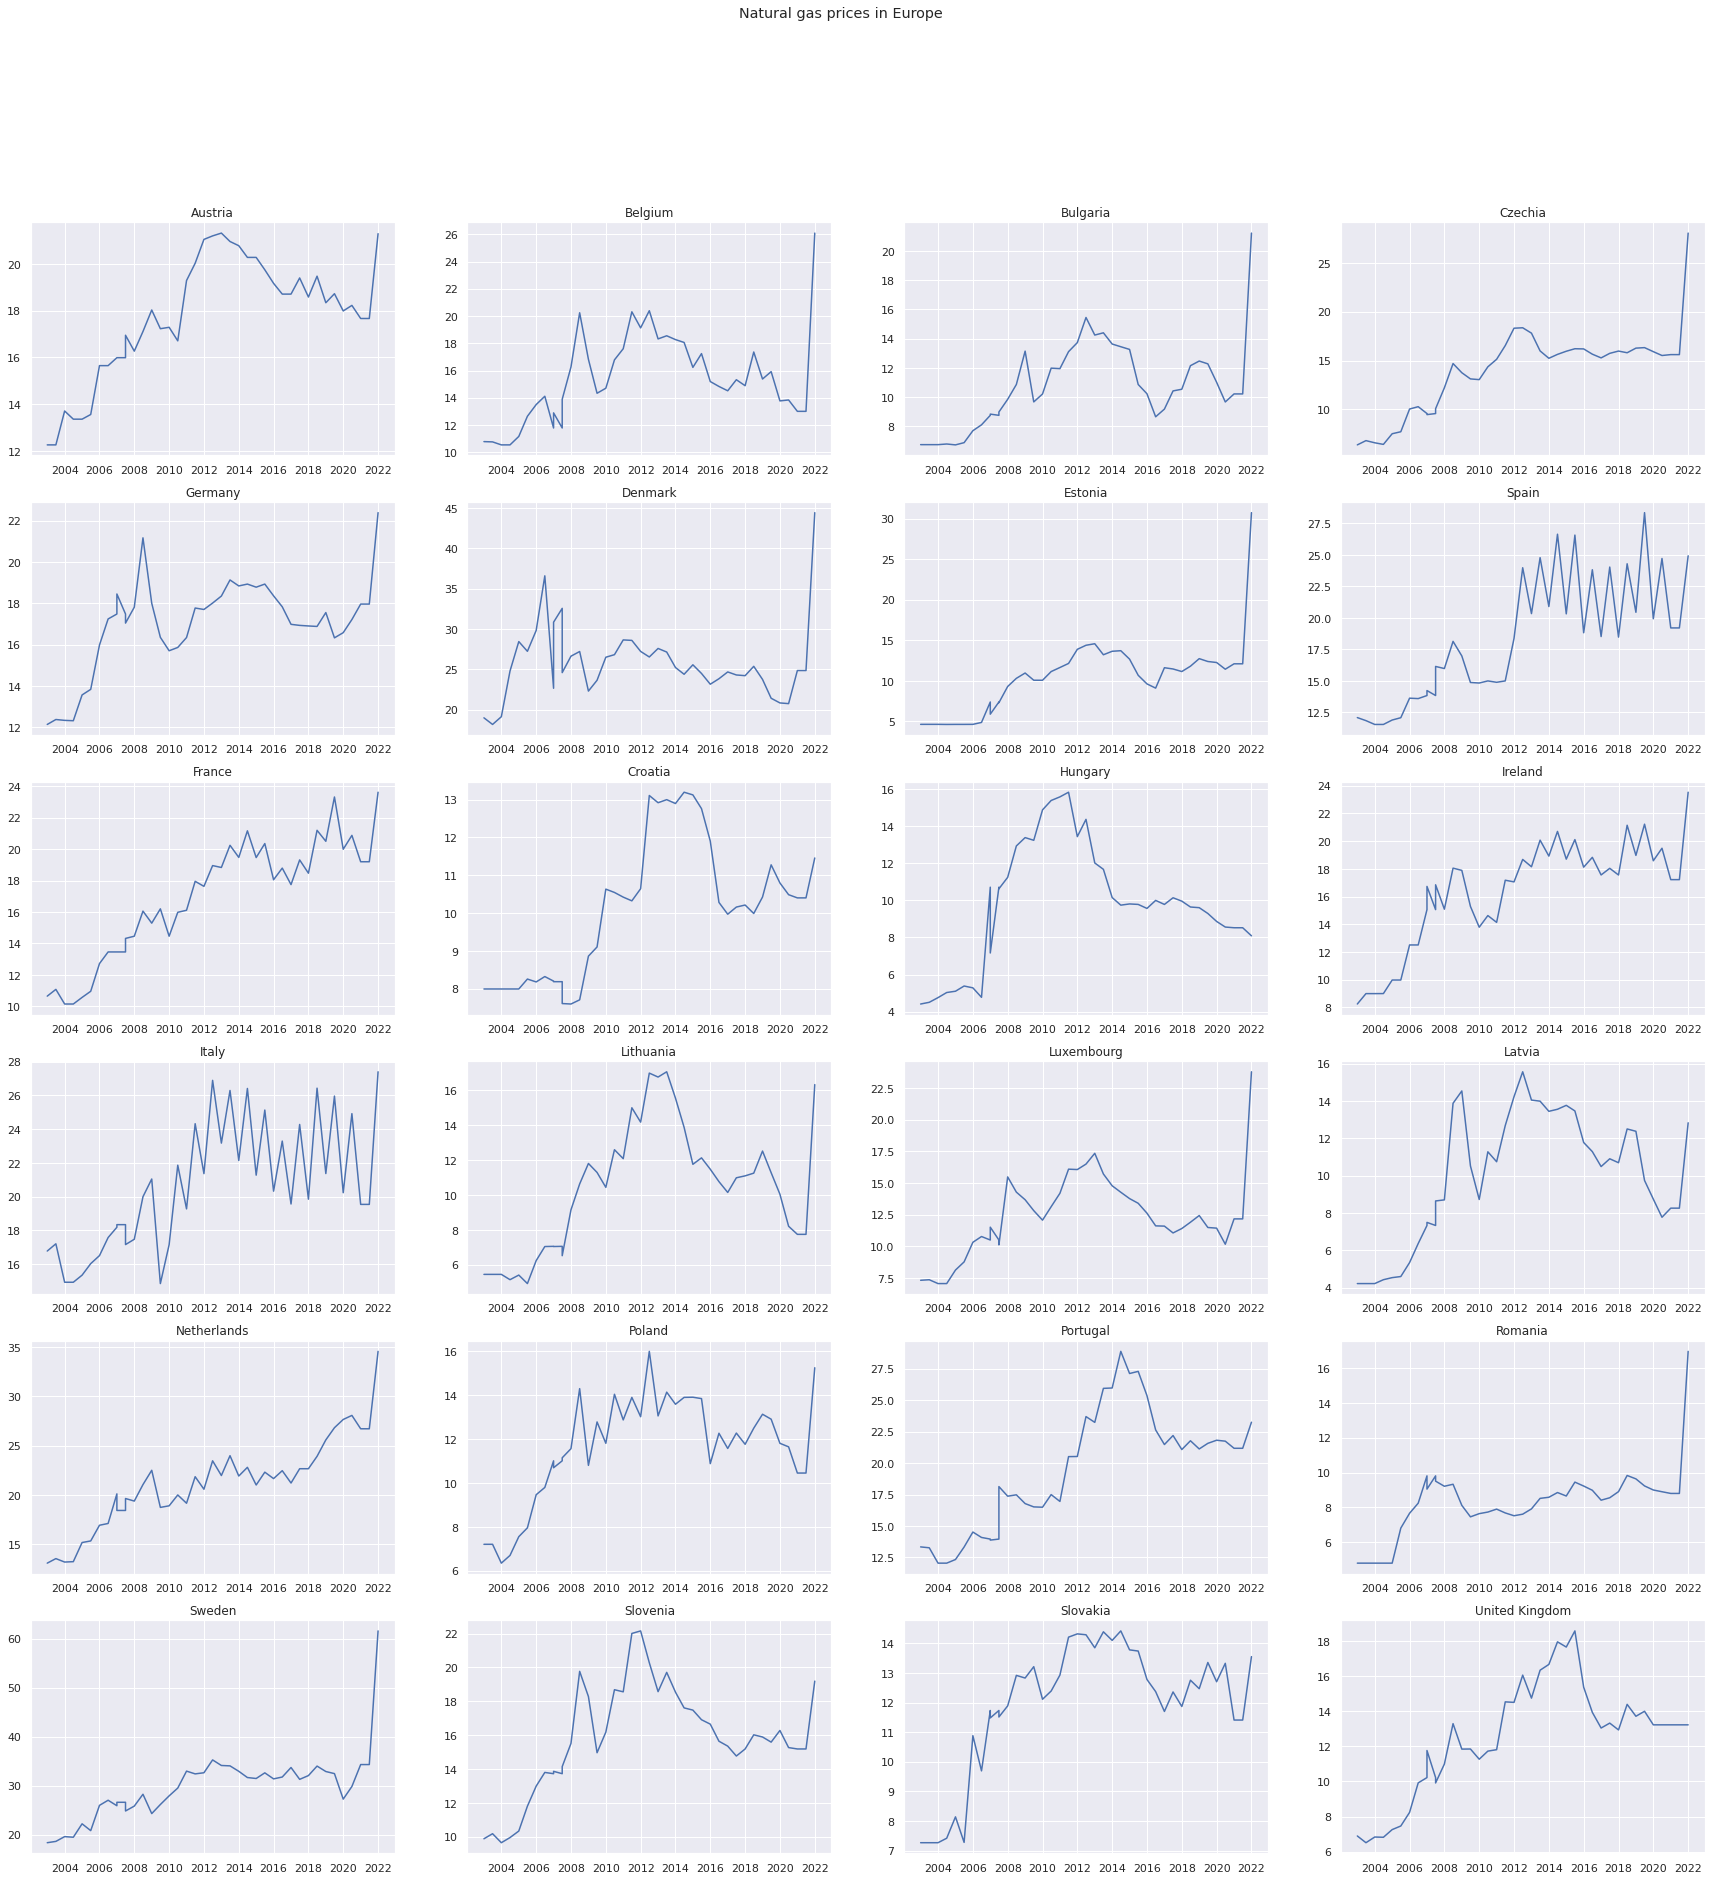

In [113]:
def plot_series(df):
  FIGSIZE = 30
  NUMBER_OF_ROWS, NUMBER_OF_COLUMNS = optimal_subplot_dimensions(df.shape[1])

  fig, axs = plt.subplots(NUMBER_OF_ROWS,NUMBER_OF_COLUMNS,figsize=(FIGSIZE,FIGSIZE))
  fig.suptitle('Natural gas prices in Europe')
  for i in range(NUMBER_OF_ROWS):
      for j in range(NUMBER_OF_COLUMNS):
          if i*NUMBER_OF_COLUMNS+j+1>len(df):
              continue
          # axs[i, j].plot(df.iloc[:, i*NUMBER_OF_COLUMNS+j].values)
          axs[i, j].plot(df.iloc[:, i*NUMBER_OF_COLUMNS+j])
          axs[i, j].set_title(df.columns[i*NUMBER_OF_COLUMNS+j])
  plt.show()
     
plot_series(final_df)

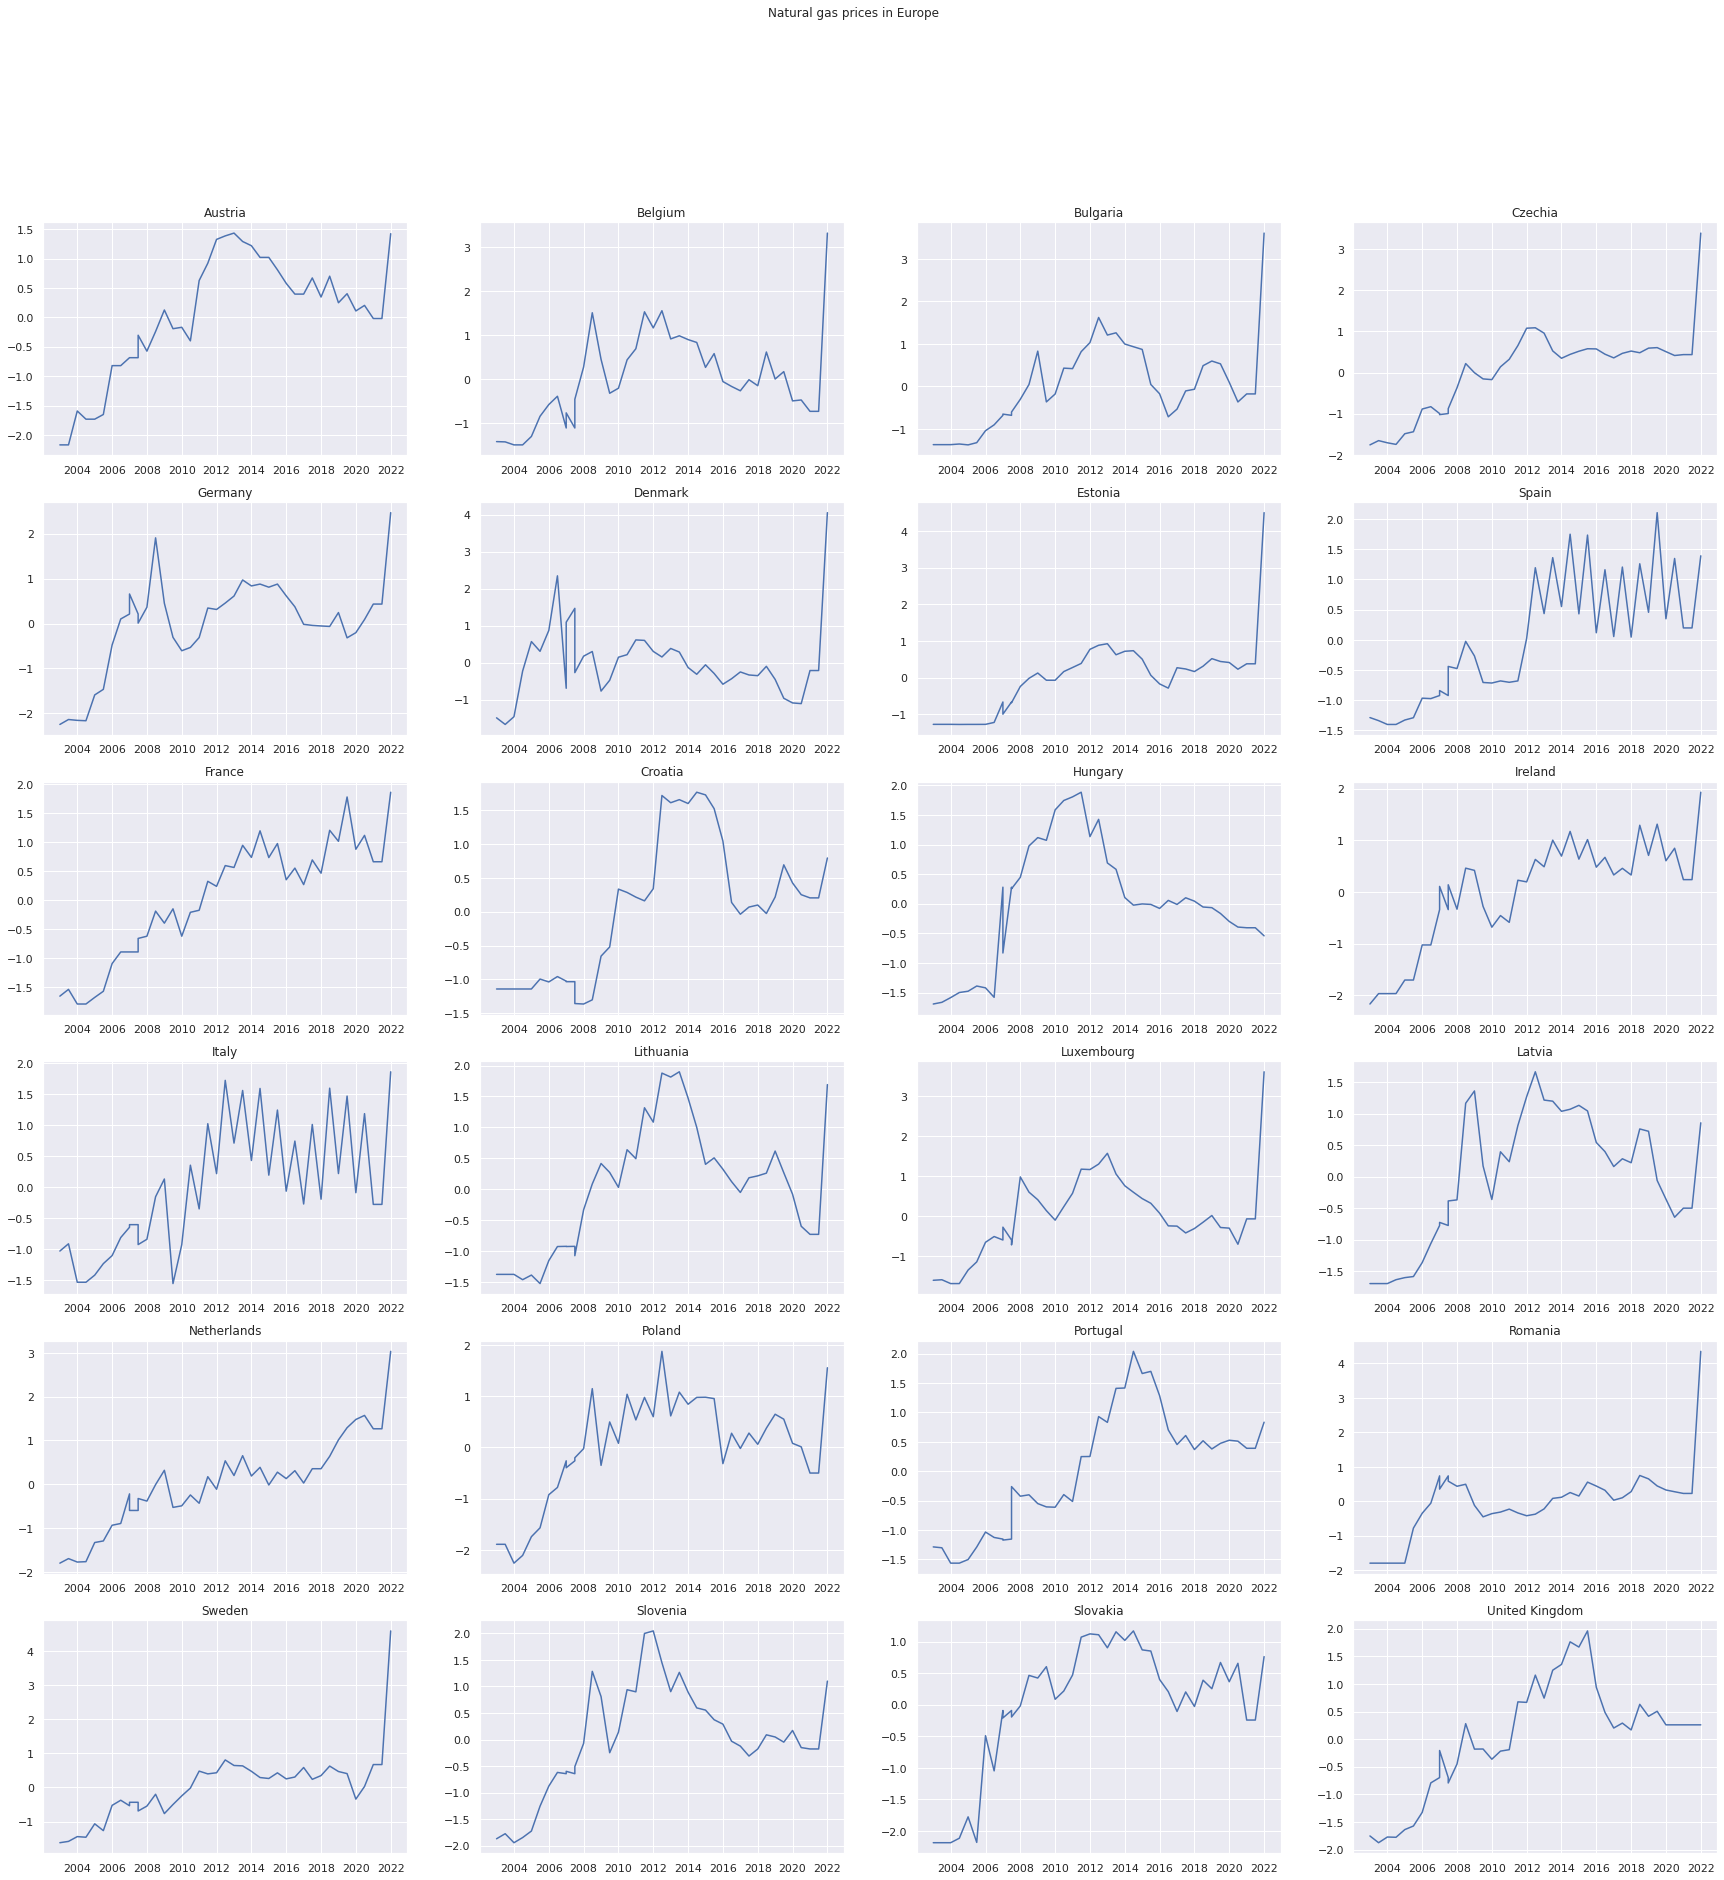

In [116]:
# Drop Turkey since it has too many NA values:
final_df = final_df.drop(columns=['Türkiye'])
scaled_df = scaled_df.drop(columns=['Türkiye'])

plot_series(scaled_df)

## Save time series to files

In [69]:
final_df.to_csv("df.csv", index=True)
scaled_df.to_csv("scaled_df.csv", index=True)

# **Clustering**

In [70]:
!pip install minisom
!pip install tslearn

from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
import math

from tslearn.clustering import TimeSeriesKMeans
from matplotlib.pyplot import figure
from tslearn.clustering import silhouette_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Helping functions

In [318]:
def find_column(df, values) -> str:
    for col in df.columns:
        if all(val in df[col].values for val in values):
            return col
    return None


def plot_clusters(df, labels):
  series = [df[column].values for column in df.columns]
  n_clusters = len(set(labels))
  rows, cols = optimal_subplot_dimensions(n_clusters)
  df_cluster_series =  pd.DataFrame(list(zip(series, labels)), columns=['series', 'cluster'])
  cluster_country_dict = df_cluster_series.groupby(['cluster'])['series'].apply(lambda x: [x for x in x]).to_dict()

  fig, axs = plt.subplots(rows, cols, figsize=(25, 15))
  fig.suptitle(f'Clusters')

  for i in range(rows):
    for j in range(cols):
        if i*cols+j+1>n_clusters: # pass the others that we can't fill
            continue
        cluster = list(cluster_country_dict.keys())[i*cols+j]
        if (cols == 1):
          for values in cluster_country_dict[cluster]:
            column = find_column(df, values)
            axs[i].plot(df[column], label=column)
          axs[i].legend()
        else:           
          for values in cluster_country_dict[cluster]:
            column = find_column(df, values)
            axs[i, j].plot(df[column],label=column)
          axs[i, j].legend()

  plt.show()

In [320]:
df = scaled_df

## Raw time series

### 𝑘-means


In [73]:
from tslearn.clustering import TimeSeriesKMeans

In [354]:
# Range of possible number of clusters
n_clusters = range(2, 5)
distance_measure = ['dtw', 'softdtw']

def kmeans(df):
  series = [df[column].tolist() for column in df.columns]
  cluster_metrics_k_means = pd.DataFrame(columns=distance_measure, index=n_clusters)

  labels_dict = {}
  for k in n_clusters:
    for measure in distance_measure:
      model = TimeSeriesKMeans(
        n_clusters=k,
        metric=measure,
        random_state=27346,
      )

      labels = model.fit_predict(series)
      score = silhouette_score(series, labels, metric=measure)
      cluster_metrics_k_means.at[k, measure] = score
      labels_dict[score] = labels

      print("\n")
      print("\n")
      print(measure)
      plot_clusters(df, labels)

  # plot_clusters(df, labels_dict[max(labels_dict)])
  return cluster_metrics_k_means





dtw


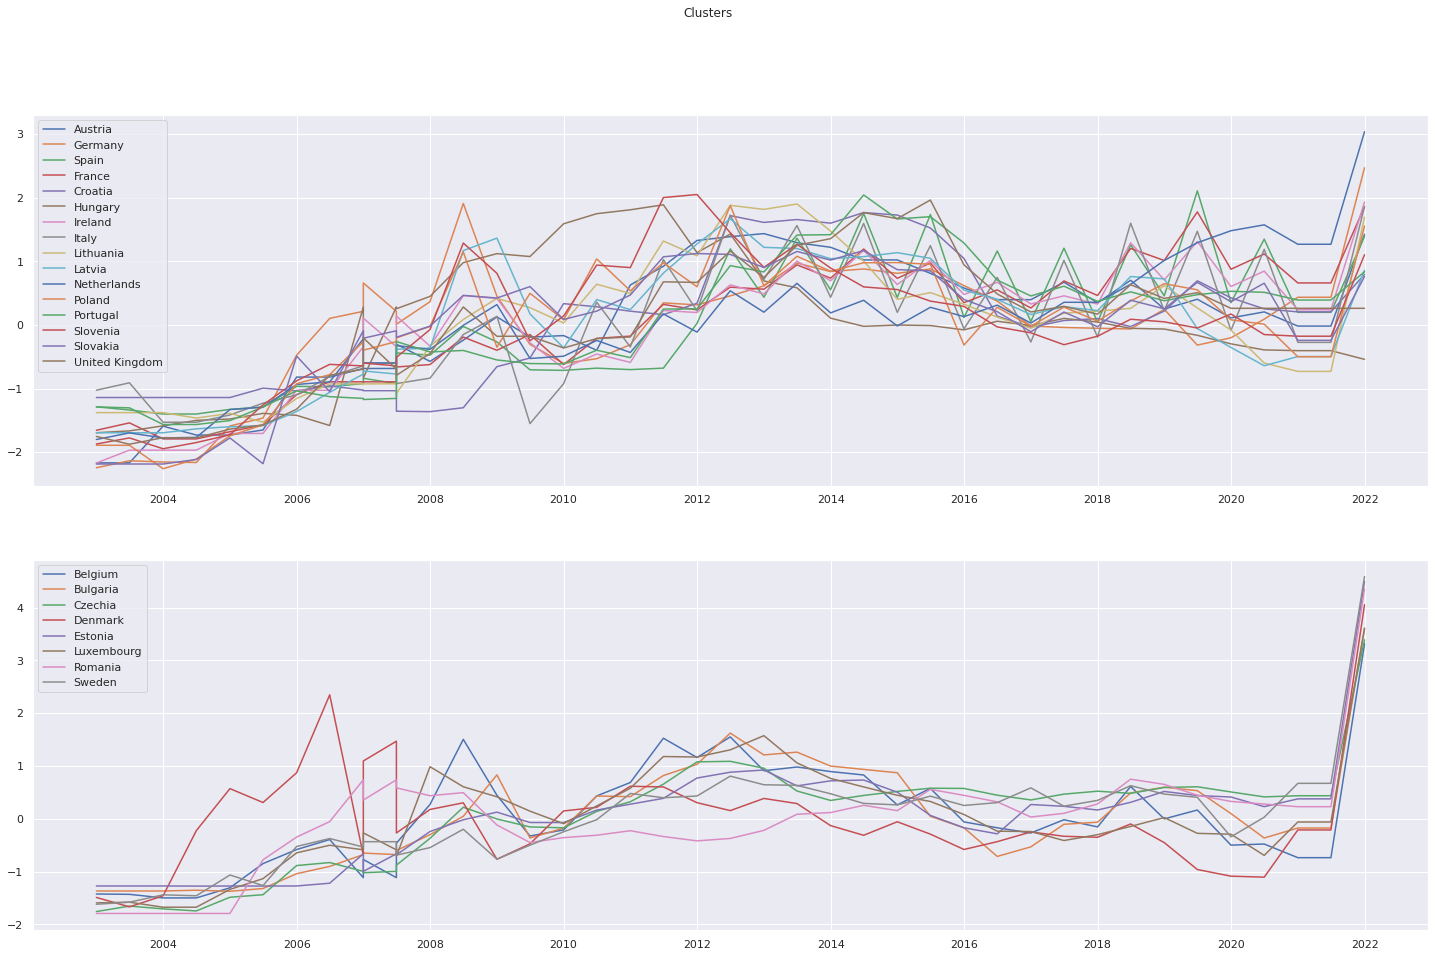





softdtw


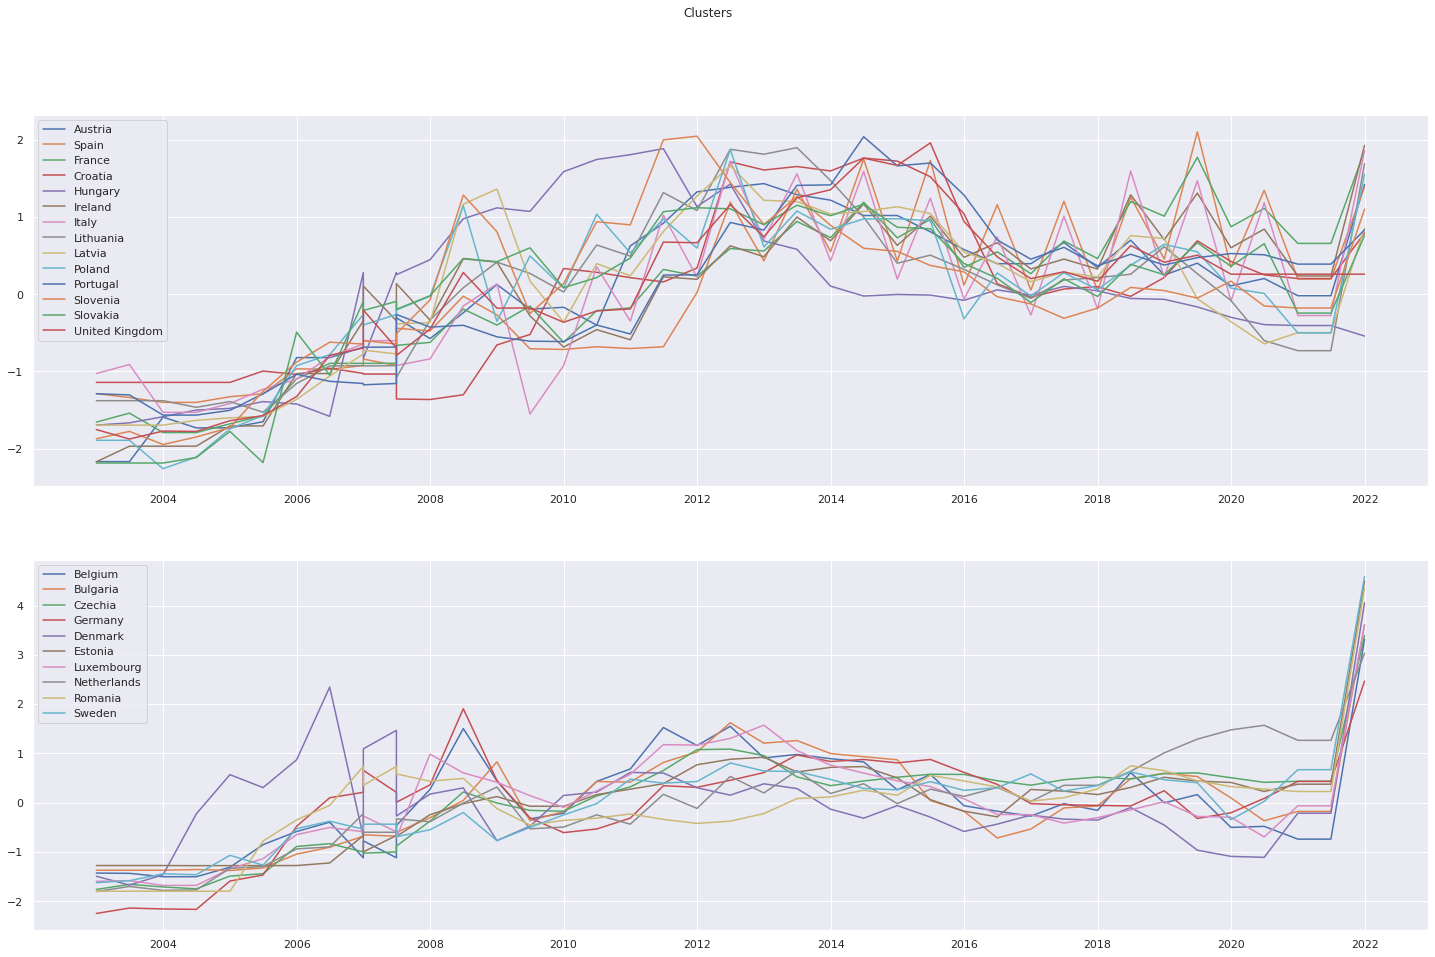





dtw


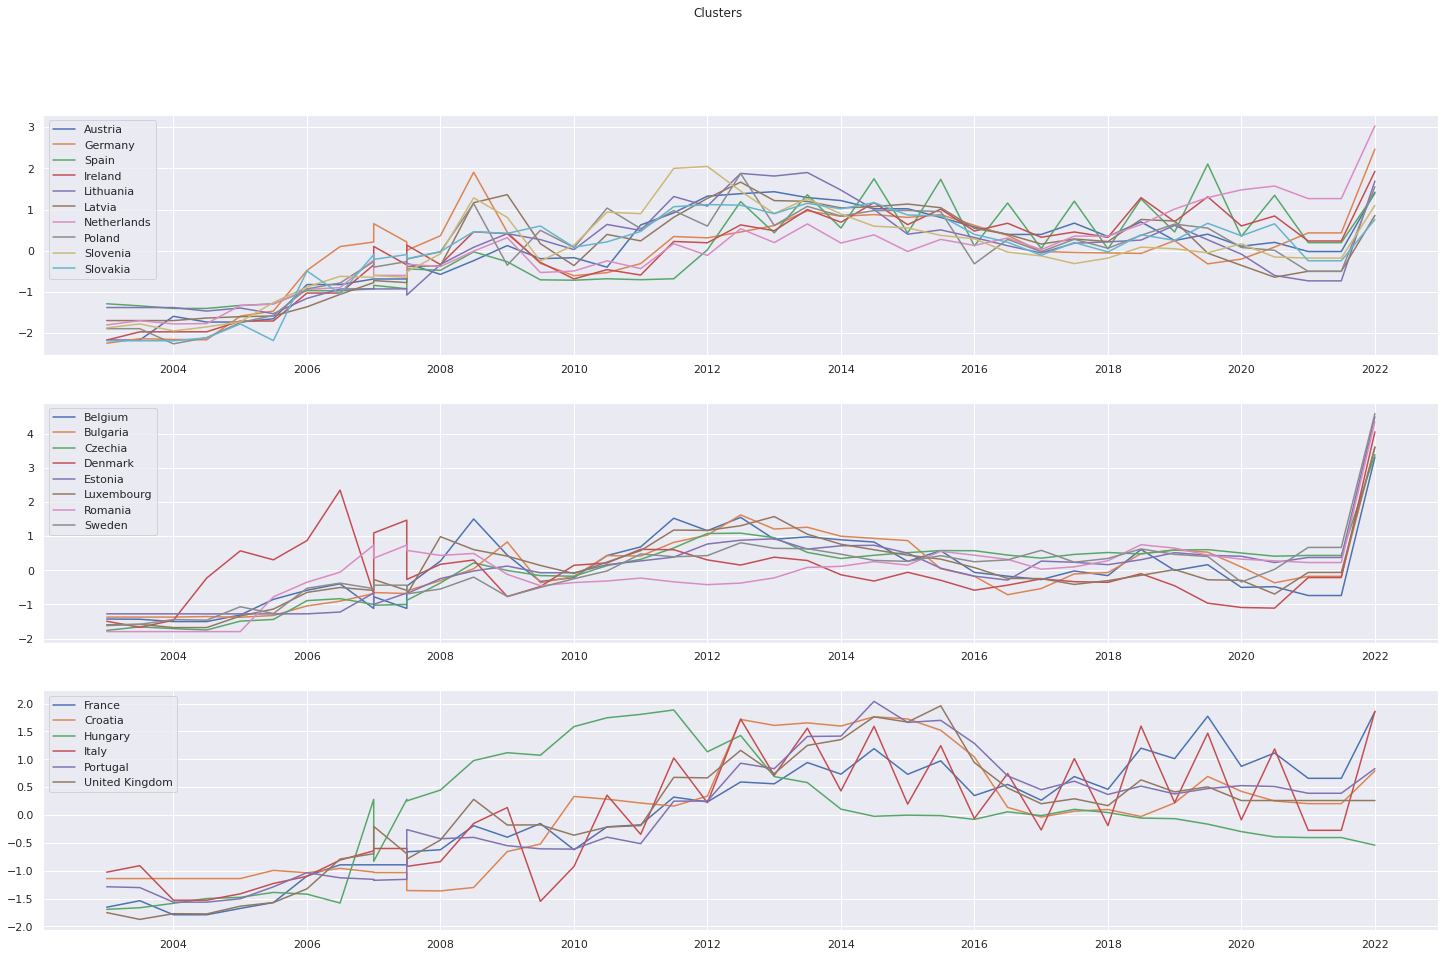





softdtw


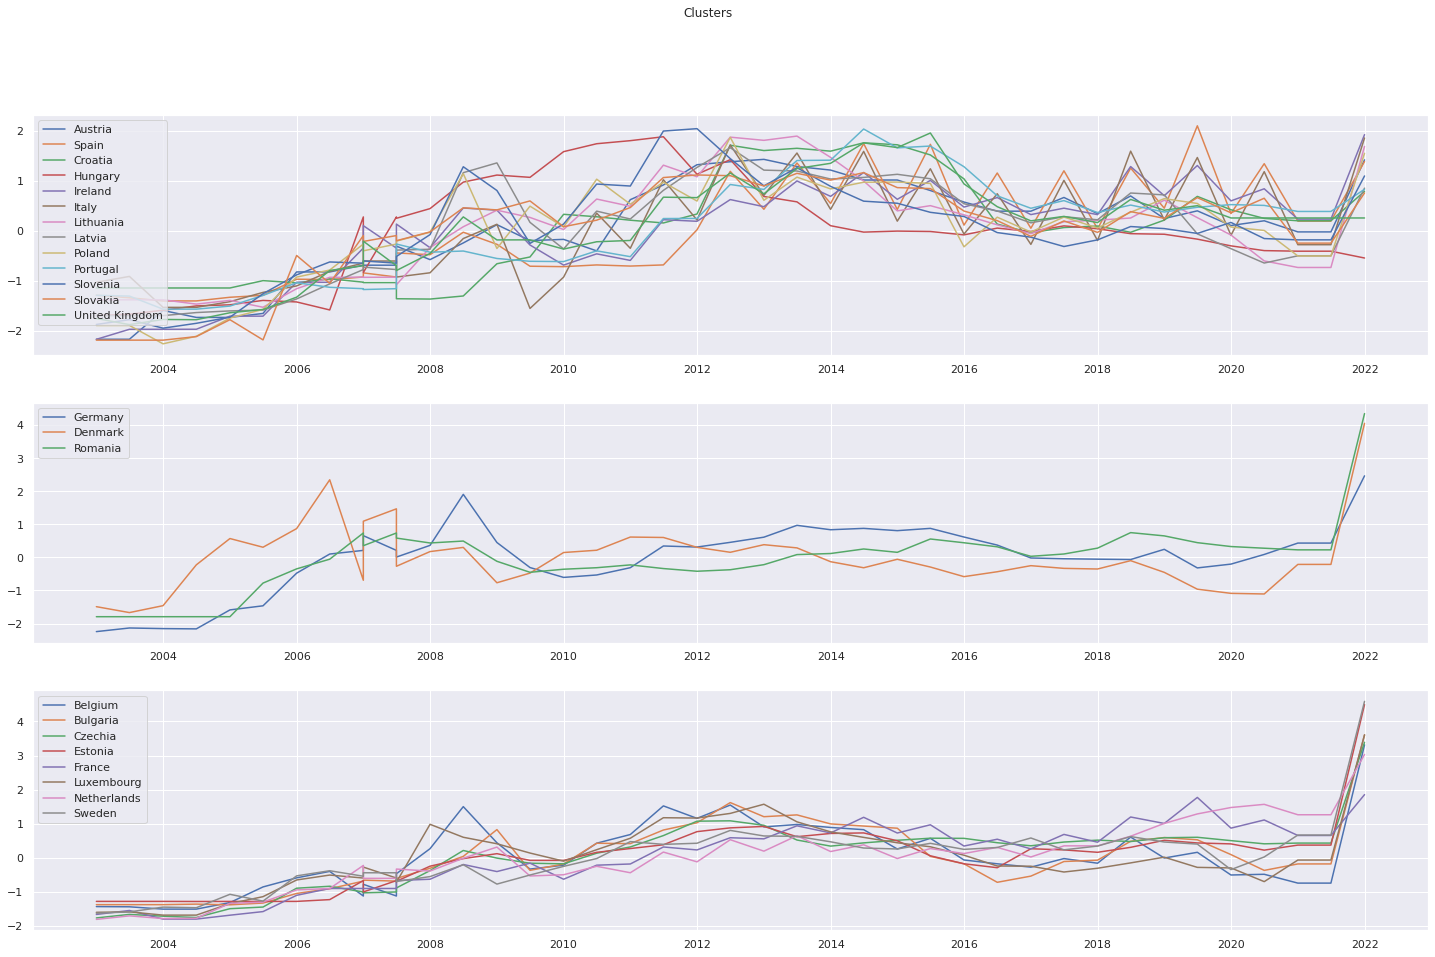





dtw


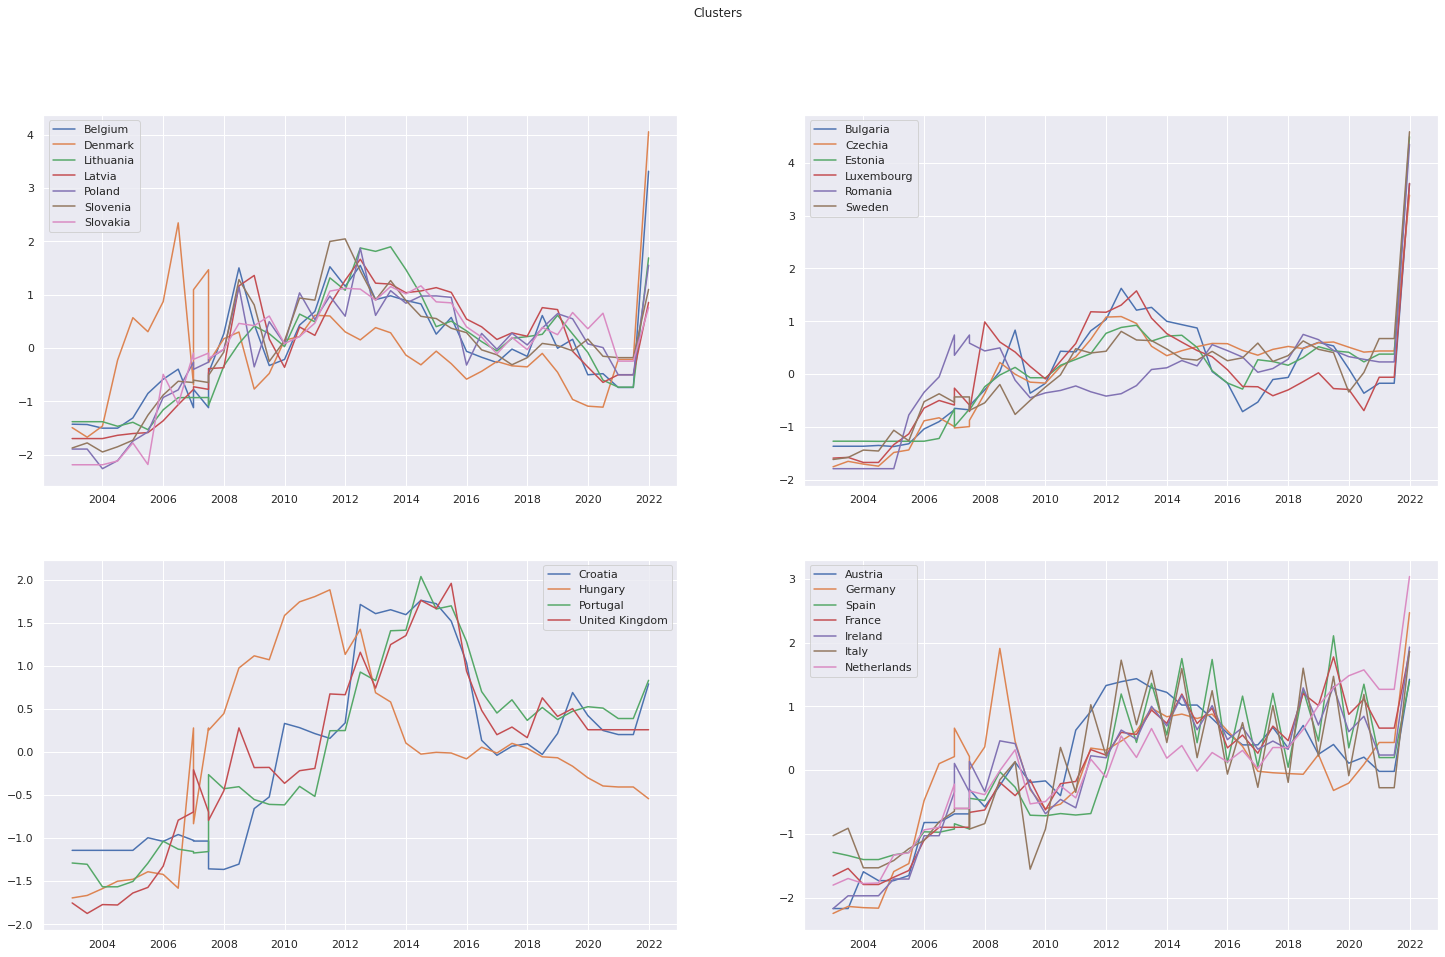





softdtw


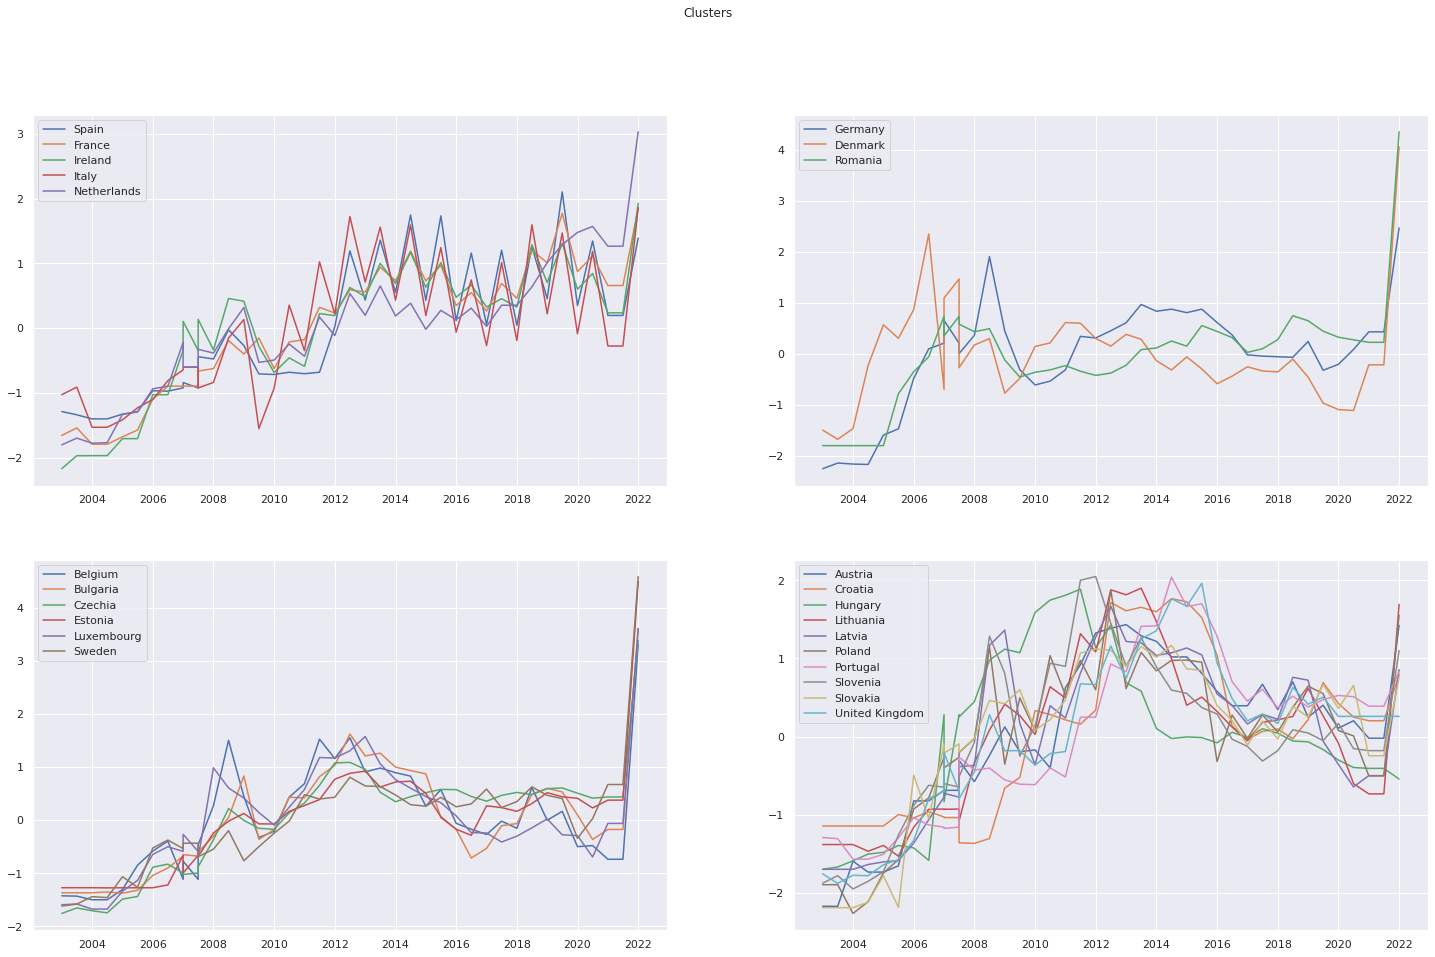

dtw   softdtw
2  0.272587   0.37452
3  0.134008  0.304937
4   0.13718    0.3608

In [355]:
kmeans(df)

### *k*-shape

In [322]:
from tslearn.clustering import KShape

n_clusters = range(4, 5)
distance_measure = ['dtw', 'softdtw']

def kshape(df):
  series = [df[column].tolist() for column in df.columns]
  cluster_metrics_k_means = pd.DataFrame(columns=distance_measure, index=n_clusters)

  labels_dict = {}
  for k in n_clusters:
    for measure in distance_measure:
      model = KShape(
        n_clusters=k,
        random_state=27346,
      )

      labels = model.fit_predict(series)
      score = silhouette_score(series, labels, metric=measure)
      cluster_metrics_k_means.at[k, measure] = score
      labels_dict[score] = labels

      print("\n")
      print("\n")
      print(measure)
      plot_clusters(df, labels)

  # plot_clusters(df, labels_dict[max(labels_dict)])
  return cluster_metrics_k_means





dtw


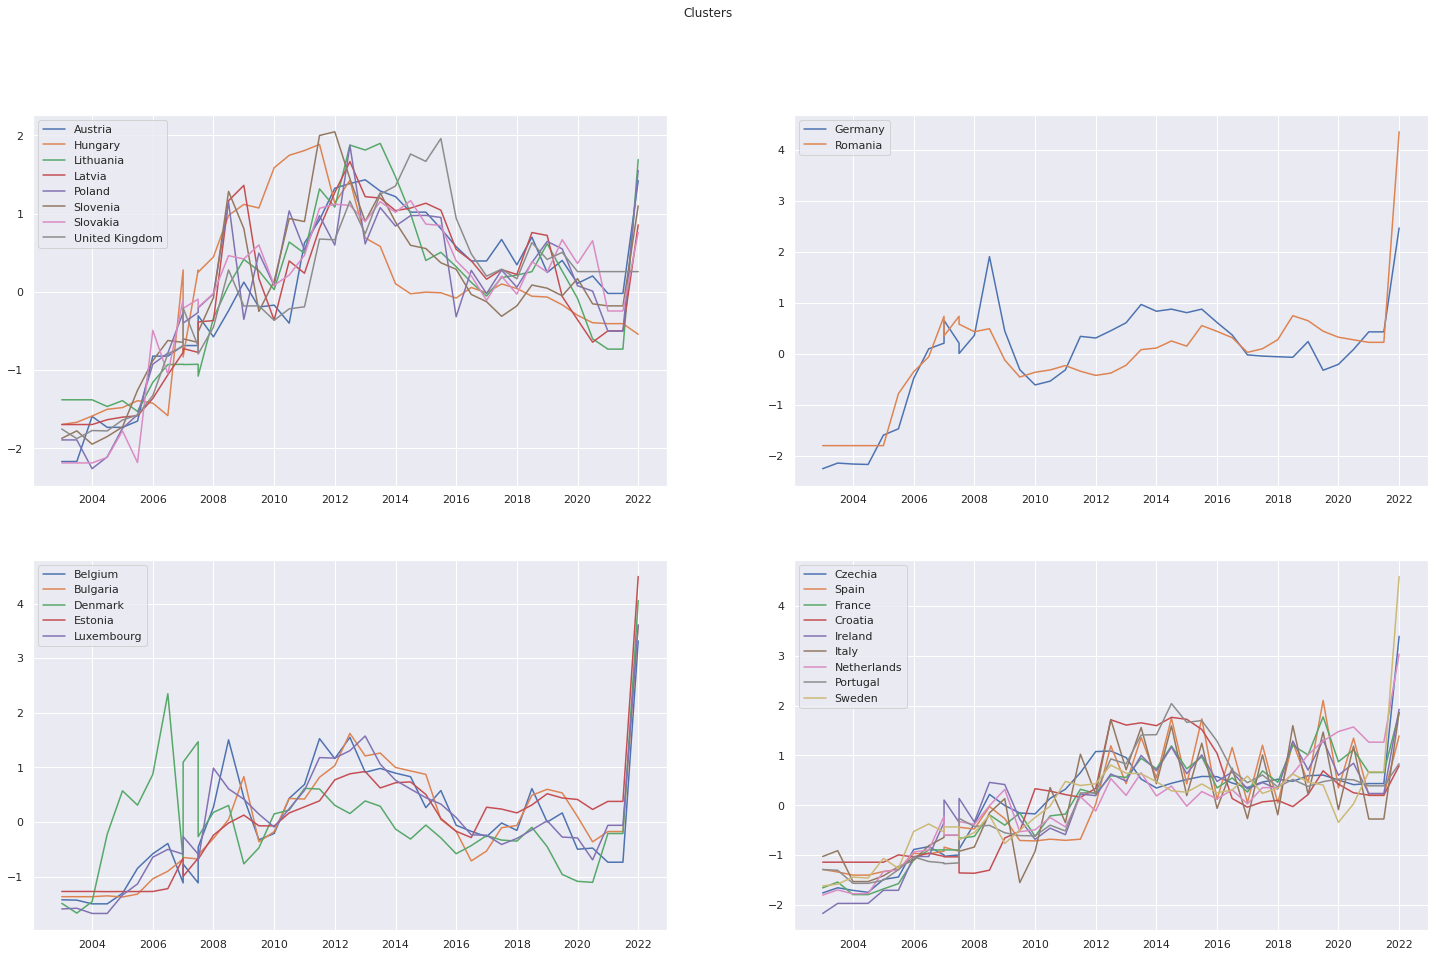





softdtw


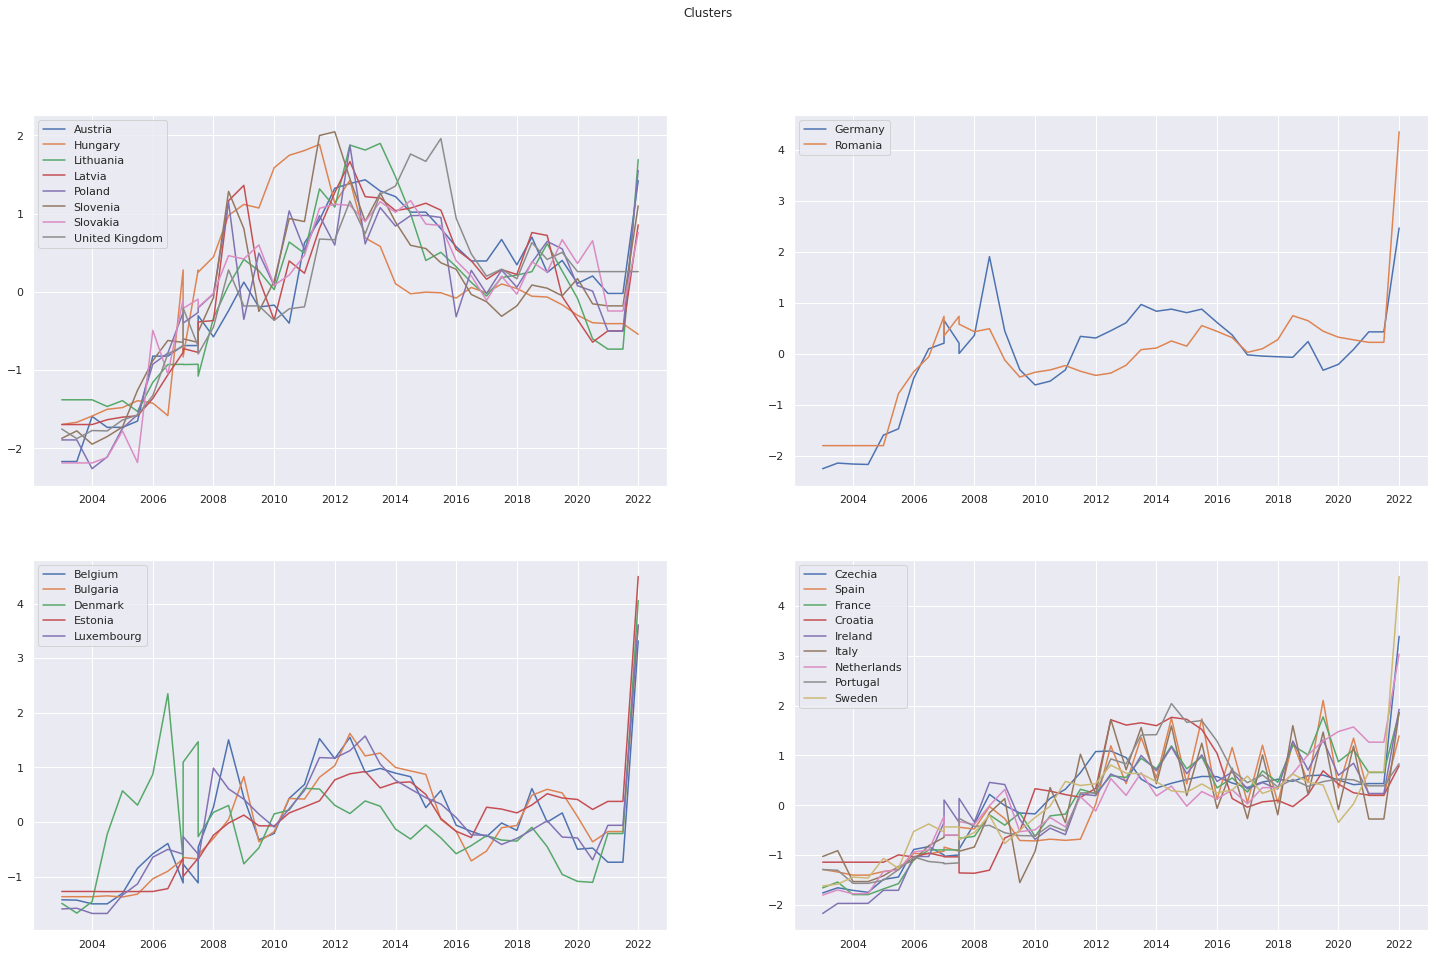

dtw   softdtw
4  0.097772  0.268841

In [323]:
kshape(df)

###  Hierarchical clustering for time series (Scipy)

In [301]:
from copy import deepcopy
from tslearn.metrics import soft_dtw
from tslearn.metrics import dtw
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram


clustering_methods = ['complete', 'single', 'average', 'ward']
n_clusters = range(2, 9)
distance_measure = ['dtw', 'softdtw']

# Build distance matrix with dtw     
def create_distance_matrix(df, measure):
  series = [df[column].tolist() for column in df.columns]
  s = [x for x in series]
  for i in range(len(series)):
      length = len(series[i])
      series[i] = np.array(series[i]).reshape((length, 1))

  # Initialize distance matrix
  n_series = len(series)
  distance_matrix = np.zeros(shape=(n_series, n_series))

  # Build distance matrix
  for i in range(n_series):
      for j in range(n_series):
          x = series[i]
          y = series[j]
          if i != j:
            if measure == "softdtw":
              dist = soft_dtw(x, y)
            else:
              dist = dtw(x, y)
            distance_matrix[i, j] = dist
  return distance_matrix


# Build a linkage matrix
def hierarchical_clustering(df, distance_matrix, measure, method='ward',):
    if method == 'complete':
        Z = complete(distance_matrix)
    if method == 'single':
        Z = single(distance_matrix)
    if method == 'average':
        Z = average(distance_matrix)
    if method == 'ward':
        Z = ward(distance_matrix)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z, labels = df.columns.tolist())
    plt.title(f"Dendrogram for {method}-linkage with distance measure: {measure}")
    plt.show()
    
    return Z

def build_clusters(linkage_matrix, k):
  cluster_labels = fcluster(linkage_matrix, k, criterion='maxclust')
  return cluster_labels


def get_hierarchical_clustering_metrics(df):
  series = [df[column].tolist() for column in df.columns]

  for measure in distance_measure:
    cluster_metrics_hierarch = pd.DataFrame(columns=clustering_methods, index=n_clusters)
    distance_matrix = create_distance_matrix(df, measure)

    for method in clustering_methods:
      linkage_matrix = hierarchical_clustering(df, distance_matrix, measure, method)

      for k in n_clusters:
        labels = build_clusters(linkage_matrix, k).tolist()
        score = silhouette_score(series, labels, metric=measure)
        cluster_metrics_hierarch.at[k, method] = score
    
    print(f"\nMetrics for distance measure {measure}")
    print("\n")
    print(cluster_metrics_hierarch.to_markdown()) 
    print("\n")

/usr/local/lib/python3.8/dist-packages/scipy/cluster/hierarchy.py:364: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


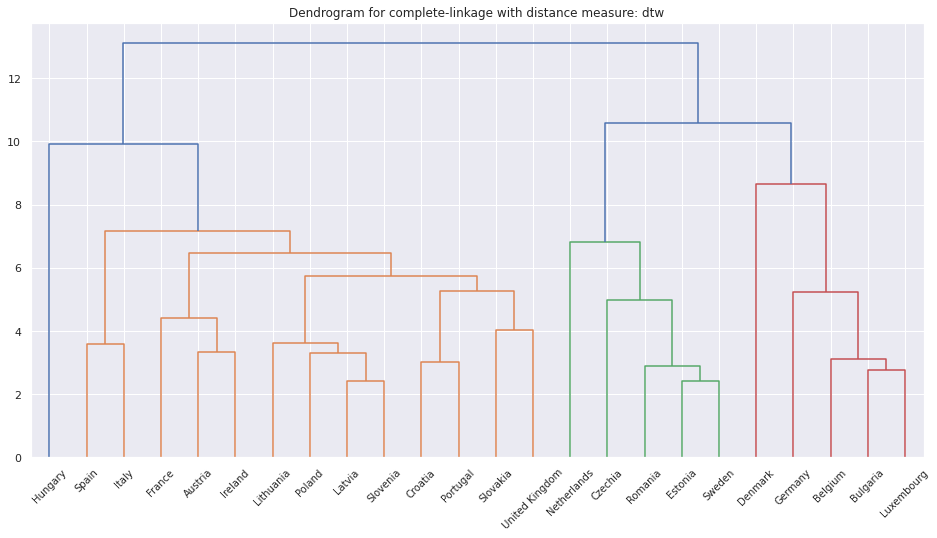

/usr/local/lib/python3.8/dist-packages/scipy/cluster/hierarchy.py:282: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='single', metric='euclidean')


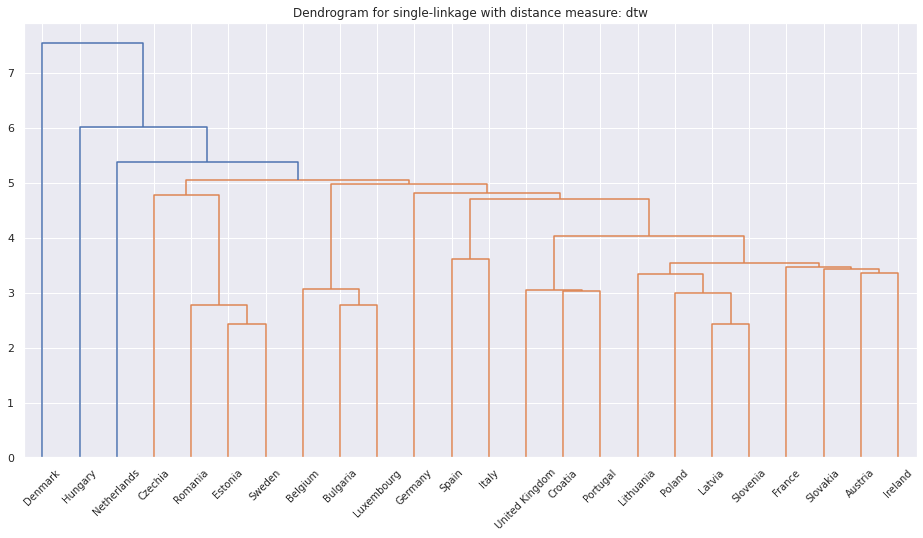

/usr/local/lib/python3.8/dist-packages/scipy/cluster/hierarchy.py:446: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='average', metric='euclidean')


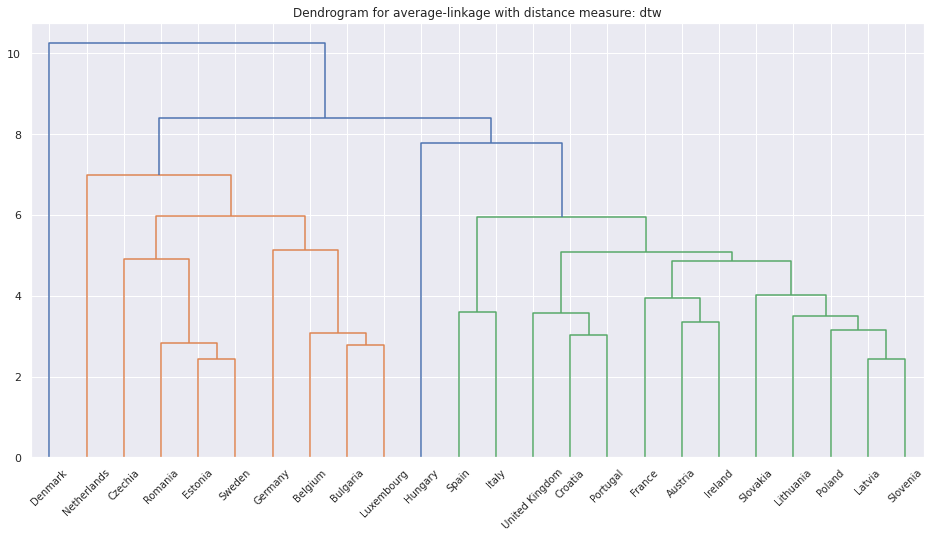

/usr/local/lib/python3.8/dist-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


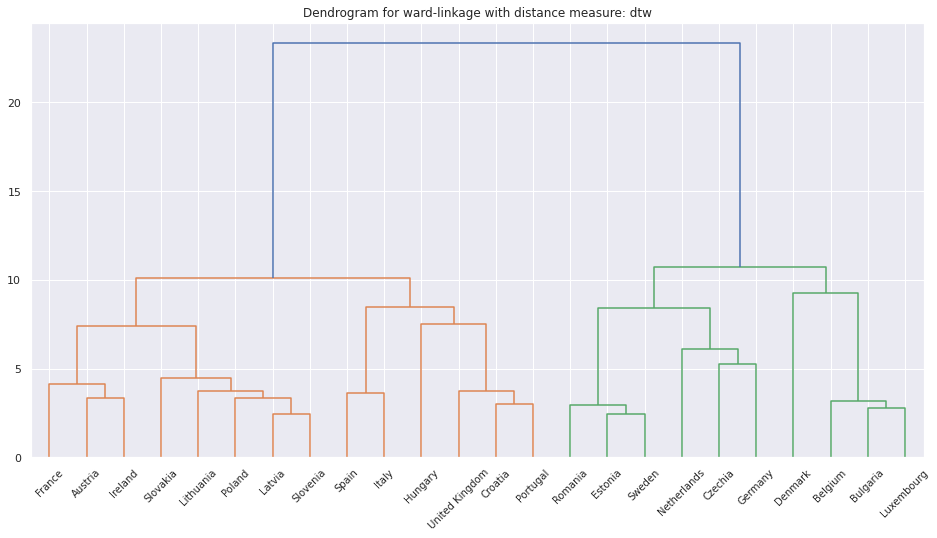


Metrics for distance measure dtw


|    |   complete |     single |   average |     ward |
|---:|-----------:|-----------:|----------:|---------:|
|  2 |   0.268094 |  0.233942  | 0.233942  | 0.268094 |
|  3 |   0.240675 |  0.0609137 | 0.232631  | 0.235045 |
|  4 |   0.168296 | -0.0529767 | 0.147941  | 0.145442 |
|  5 |   0.15005  |  0.0554505 | 0.0996895 | 0.136917 |
|  6 |   0.177069 |  0.119395  | 0.119909  | 0.170764 |
|  7 |   0.154594 |  0.122475  | 0.154594  | 0.157604 |
|  8 |   0.13023  |  0.0775777 | 0.159072  | 0.157561 |




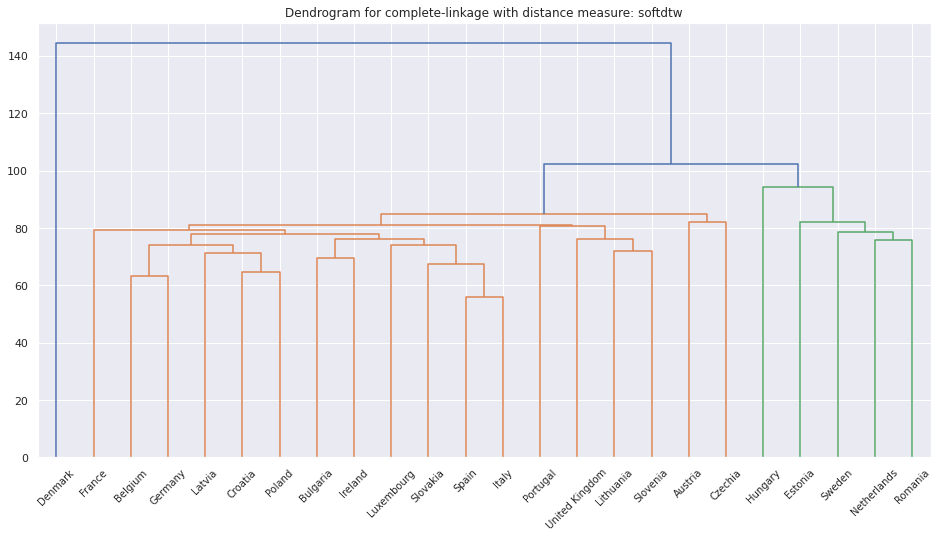

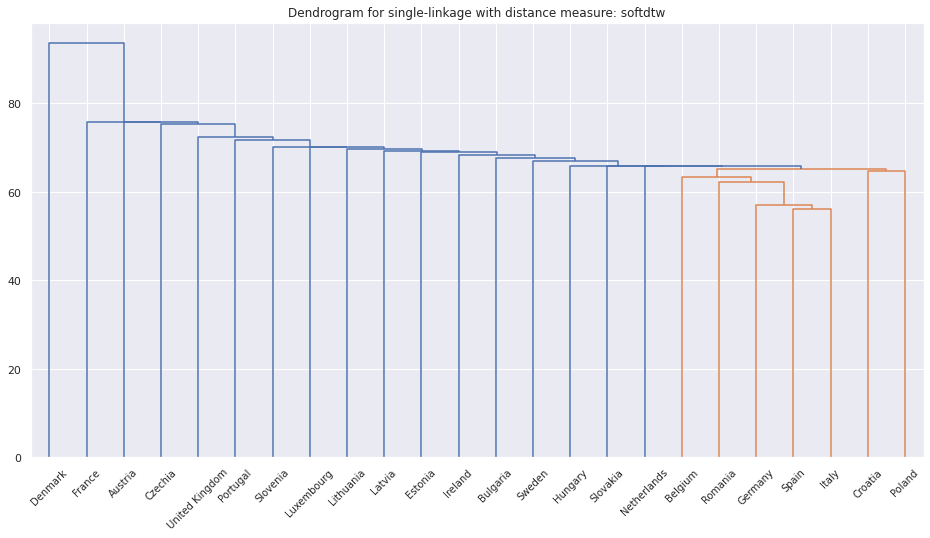

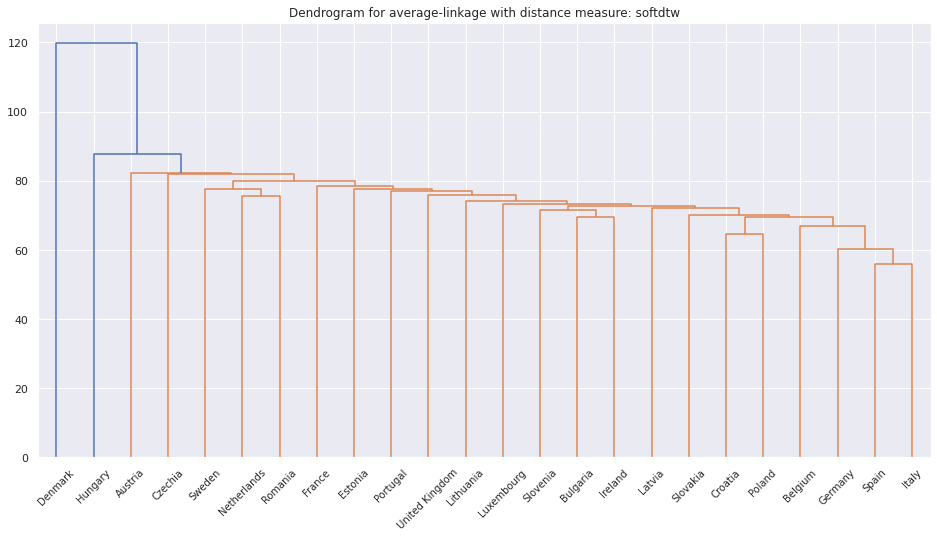

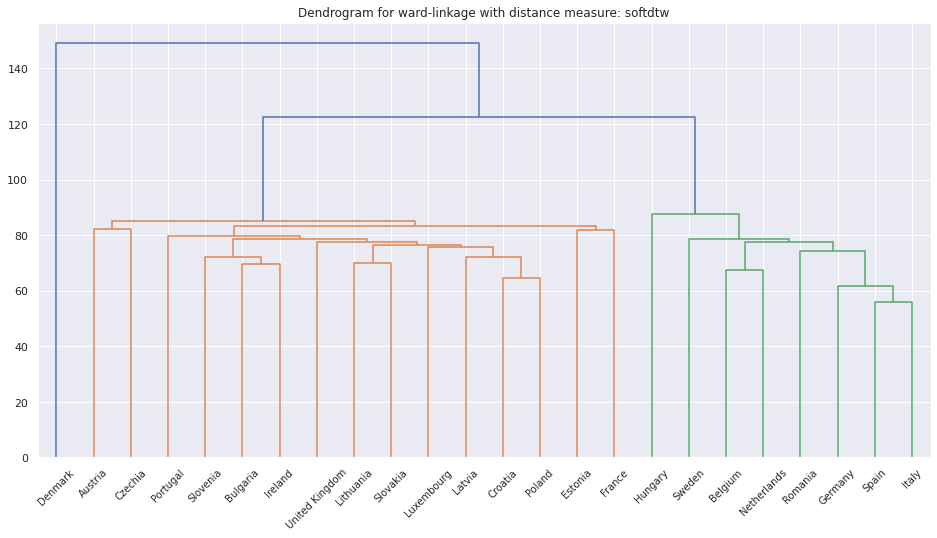


Metrics for distance measure softdtw


|    |   complete |    single |   average |        ward |
|---:|-----------:|----------:|----------:|------------:|
|  2 |  0.457712  |  0.457712 |  0.457712 |  0.457712   |
|  3 |  0.251855  | -0.110134 |  0.168014 |  0.0970286  |
|  4 |  0.148728  | -0.37165  | -0.29096  | -0.00128548 |
|  5 | -0.0889053 | -0.425065 | -0.389096 | -0.181535   |
|  6 | -0.287878  | -0.41068  | -0.313803 | -0.189075   |
|  7 | -0.310956  | -0.385916 | -0.325105 | -0.339415   |
|  8 | -0.28971   | -0.40398  | -0.322761 | -0.350468   |




In [302]:
get_hierarchical_clustering_metrics(df)

## Feature-based clustering

### tsfresh

In [ ]:
!pip install tsfresh

In [223]:
from tsfresh import extract_features

# Prepare df for tsfresh format
def transform_df(df):
  rows = []
  for col in df:
    country = col
    for idx, value in df[col].iteritems():
      rows.append((country, idx, value))
  new_df = pd.DataFrame(rows, columns=['id', 'time', 'value'])
  return new_df

tsfresf_df = transform_df(df)
tsfresf_df

id       time     value
0           Austria 2003-01-01 -2.168039
1           Austria 2003-07-01 -2.168039
2           Austria 2004-01-01 -1.591642
3           Austria 2004-07-01 -1.730772
4           Austria 2005-01-01 -1.730772
..              ...        ...       ...
979  United Kingdom 2020-01-01  0.260043
980  United Kingdom 2020-07-01  0.260043
981  United Kingdom 2021-01-01  0.260043
982  United Kingdom 2021-07-01  0.260043
983  United Kingdom 2022-01-01  0.260043

[984 rows x 3 columns]

In [305]:
from tsfresh.feature_extraction import extract_features, ComprehensiveFCParameters, EfficientFCParameters
from tsfresh.feature_extraction.settings import MinimalFCParameters

# extract features
extracted_features = extract_features(tsfresf_df, column_id="id", column_sort="time", default_fc_parameters=ComprehensiveFCParameters())
extracted_features = extracted_features.transpose()

# drop na
extracted_features = extracted_features.dropna()
extracted_features = extracted_features.drop_duplicates()

# scaling
# extracted_features = pd.DataFrame(r_scaler.fit_transform(extracted_features), columns=extracted_features.columns, index=extracted_features.index)

Feature Extraction: 100%|██████████| 24/24 [00:02<00:00, 11.60it/s]


In [306]:
extracted_features

Austria       Belgium  \
value__variance_larger_than_standard_deviation  1.000000e+00  0.000000e+00   
value__has_duplicate_max                        0.000000e+00  0.000000e+00   
value__has_duplicate_min                        1.000000e+00  1.000000e+00   
value__has_duplicate                            1.000000e+00  1.000000e+00   
value__sum_values                              -4.662937e-15  1.287859e-14   
...                                                      ...           ...   
value__permutation_entropy__dimension_4__tau_1  2.556200e+00  2.581154e+00   
value__permutation_entropy__dimension_5__tau_1  3.092903e+00  3.236244e+00   
value__permutation_entropy__dimension_6__tau_1  3.321478e+00  3.467994e+00   
value__permutation_entropy__dimension_7__tau_1  3.461181e+00  3.555348e+00   
value__mean_n_absolute_max__number_of_maxima_7  1.781997e+00  1.761148e+00   

                                                    Bulgaria       Croatia  \
value__variance_larger_than_standard_deviation  0.000000e+00  1.000000e+00   
value__has_duplicate_max                        0.000000e+00  0.000000e+00   
value__has_duplicate_min                        0.000000e+00  0.000000e+00   
value__has_duplicate                            1.000000e+00  1.000000e+00   
value__sum_values                               9.769963e-15 -4.174439e-14   
...                                                      ...           ...   
value__permutation_entropy__dimension_4__tau_1  2.366876e+00  2.727843e+00   
value__permutation_entropy__dimension_5__tau_1  3.065403e+00  3.297037e+00   
value__permutation_entropy__dimension_6__tau_1  3.390978e+00  3.545011e+00   
value__permutation_entropy__dimension_7__tau_1  3.515740e+00  3.555348e+00   
value__mean_n_absolute_max__number_of_maxima_7  1.723551e+00  1.655620e+00   

                                                     Czechia       Denmark  \
value__variance_larger_than_standard_deviation  0.000000e+00  0.000000e+00   
value__has_duplicate_max                        0.000000e+00  0.000000e+00   
value__has_duplicate_min                        0.000000e+00  0.000000e+00   
value__has_duplicate                            1.000000e+00  1.000000e+00   
value__sum_values                              -1.421085e-14  2.131628e-14   
...                                                      ...           ...   
value__permutation_entropy__dimension_4__tau_1  2.392861e+00  2.743435e+00   
value__permutation_entropy__dimension_5__tau_1  3.131154e+00  3.334504e+00   
value__permutation_entropy__dimension_6__tau_1  3.429486e+00  3.506503e+00   
value__permutation_entropy__dimension_7__tau_1  3.515740e+00  3.515740e+00   
value__mean_n_absolute_max__number_of_maxima_7  1.883033e+00  1.942820e+00   

                                                     Estonia        France  \
value__variance_larger_than_standard_deviation  1.000000e+00  0.000000e+00   
value__has_duplicate_max                        0.000000e+00  0.000000e+00   
value__has_duplicate_min                        0.000000e+00  1.000000e+00   
value__has_duplicate                            1.000000e+00  1.000000e+00   
value__sum_values                              -4.440892e-15  1.287859e-14   
...                                                      ...           ...   
value__permutation_entropy__dimension_4__tau_1  2.363870e+00  2.242108e+00   
value__permutation_entropy__dimension_5__tau_1  3.055436e+00  2.706742e+00   
value__permutation_entropy__dimension_6__tau_1  3.321478e+00  2.959564e+00   
value__permutation_entropy__dimension_7__tau_1  3.461181e+00  3.208581e+00   
value__mean_n_absolute_max__number_of_maxima_7  1.734294e+00  1.731533e+00   

                                                     Germany       Hungary  \
value__variance_larger_than_standard_deviation  1.000000e+00  0.000000e+00   
value__has_duplicate_max                        0.000000e+00  0.000000e+00   
value__has_duplicate_min                        0.000000e+00  0.000000e

#### Kmeans

In [307]:
from sklearn.cluster import KMeans as sklearn_kmeans
from sklearn.metrics import silhouette_score as sklearn_silhouette_score

model = sklearn_kmeans(
  n_clusters=4,
  random_state=27346,
)

series = [extracted_features[column].tolist() for column in extracted_features.columns]
labels = model.fit_predict(series)
score = sklearn_silhouette_score(series, labels)
score

0.578629452726572

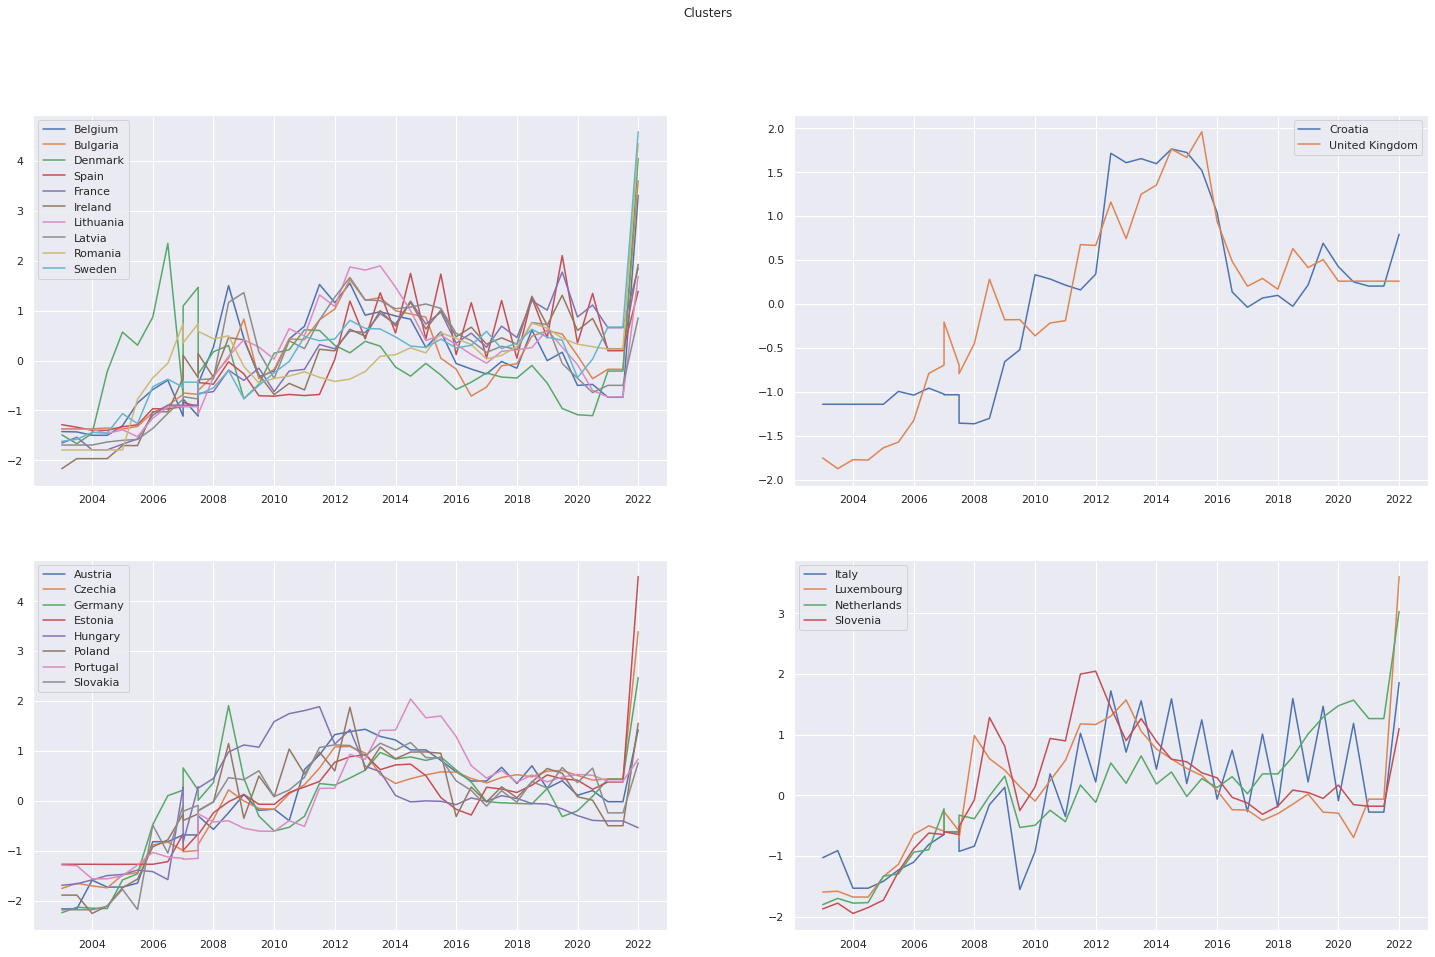

In [308]:
plot_clusters(df, labels)

## R packages

In [80]:
!pip uninstall rpy2 -y
!pip install rpy2==3.0.0
%load_ext rpy2.ipython

Found existing installation: rpy2 3.0.0
Uninstalling rpy2-3.0.0:
  Successfully uninstalled rpy2-3.0.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached rpy2-3.0.0-py3-none-any.whl


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [ ]:
# install r packages
%%R
install.packages("dtwclust", repos = "http://cran.us.r-project.org")
install.packages("dplyr", repos = "http://cran.us.r-project.org")

In [ ]:
# install data as r dataframes
%%R
r_scaled_df <- read.csv("scaled_df.csv")
r_scaled_df <- r_scaled_df[,-1]
series <- as.list(r_scaled_df)

library(dtwclust)

### dtwclust: hierarchical

[1] "softdtw"


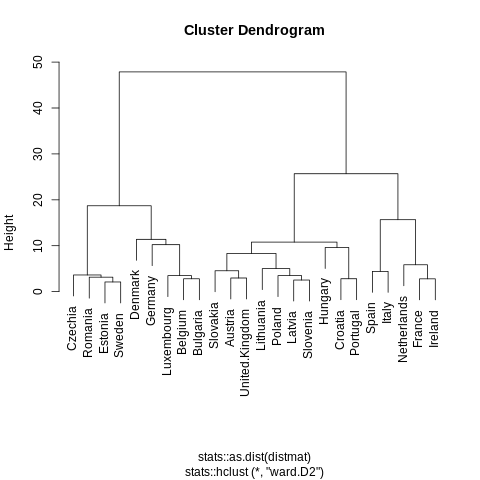

In [99]:
%%R
print("softdtw")
clustering <- tsclust(
      series,
      k = 4L,
      type = "hierarchical",
      distance = "sdtw",
      seed = 42L,
      control =
        hierarchical_control(method = "ward.D2")
    )
plot(clustering)

[1] "dtw"


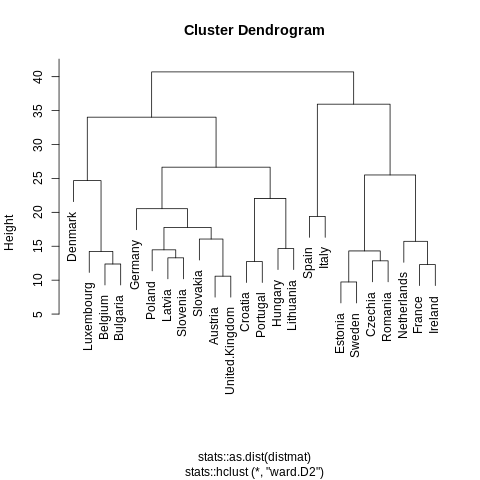

In [100]:
%%R
print("dtw")
clustering <- tsclust(
        series,
        k = 4L,
        type = "hierarchical",
        distance = "dtw",
        seed = 42L,
        control =
          hierarchical_control(method = "ward.D2")
      )
plot(clustering)

[1] "sbd"


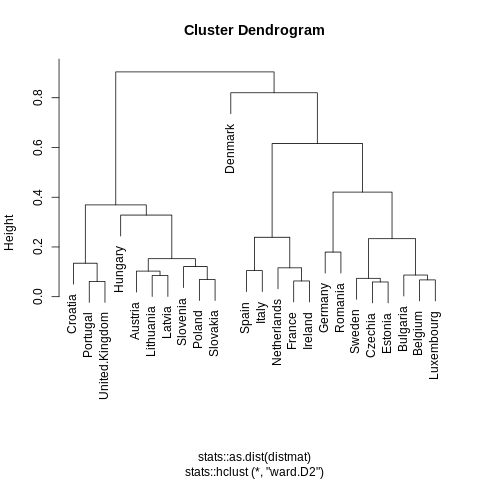

In [103]:
%%R
print("sbd")
clustering <- tsclust(
        series,
        k = 4L,
        type = "hierarchical",
        distance = "sbd",
        seed = 42L,
        control =
          hierarchical_control(method = "ward.D2")
      )
plot(clustering)

In [104]:
# R hierarch clustering metrics
%%R
library(dplyr)
get_metrics <- function(series) {
  k <- 2:8

  method <- c("ward.D2")

  distance = c("sdtw")

  
  hc_par <- tsclust(
    series,
    k = k,
    type = "hierarchical",
    distance = distance,
    seed = 42,
    control = hierarchical_control(method = method),
    args = tsclust_args(dist = list(window.size = 7)),
    trace = TRUE)

  sapply(hc_par, cvi, type = c("Sil", "D", "CH"))
}

get_metrics(series)


Calculating distance matrix...
Performing hierarchical clustering...
Extracting centroids...

	Elapsed time is 0.202 seconds.

          [,1]       [,2]       [,3]      [,4]      [,5]      [,6]      [,7]
Sil  0.4514828  0.3722080  0.3464292 0.3644055 0.3586606 0.3116935 0.3345260
D    0.1209822  0.1329187  0.1874164 0.2708430 0.2976972 0.3468289 0.3601082
CH  15.2922986 13.8244826 11.3729997 9.5860310 8.5866170 8.1709558 7.4845305
